In [1]:
%%HTML
<script src="require.js"></script>

In [2]:
from IPython.display import display, HTML
HTML('''<script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js "></script><script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
} else {
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
''')

In [3]:
# For Loading the Data
import pandas as pd
import numpy as np

# For Dimensionality Reduction
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler

# For Clustering
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import SpectralClustering as SC

# For Outlier Analysis
from matplotlib.colors import LogNorm
from sklearn import mixture
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

# For Evaluation
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn import metrics

# For Visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from itertools import cycle
import matplotlib.cm as cm
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from matplotlib import pyplot
from matplotlib.colors import LinearSegmentedColormap

sns.set_style({'axes.grid' : False})
sns.set_style('whitegrid')
custom_palette = ['#3370AC', '#FFCF64']

cmap = LinearSegmentedColormap.from_list("my_blue_cmap", 
                                         ["lightblue", "darkblue"])

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ayz3lr75 because the default path (/home/jverdan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
# Functions Used

def internalValidation(data, clusters):
    '''
    Accepts the dataset and the resulting cluster labels then
    returns a dict of internal validation scores of the cluster results.
    '''
    scores = {}
    scores['silhouette'] =metrics.silhouette_score(data, clusters, 
                                                   metric='euclidean')
    scores['calinski_harabaz'] = metrics.calinski_harabasz_score(data, 
                                                                 clusters)
    scores['davies_bouldin'] = metrics.davies_bouldin_score(data, 
                                                            clusters)
    return scores

def radarplot(df, title, height, width, bound):
    """Plot radar chart given the dataframe and title"""
    categories = df[0].columns
    fig = make_subplots(rows=1, cols=len(df), 
                        specs=[[{'type': 'polar'} for i in range(len(df))]],
                       subplot_titles=title)

    for index, d in enumerate(df):
        for g in d.index:
            fig.add_trace(go.Scatterpolar(
                r = d.loc[g].values,
                theta = categories,
                fill='toself',
                name = f'{title[index]}cluster {g}'
            ),row=1, col=index+1)

        fig.update_layout(
          polar=dict(
            radialaxis=dict(
              visible=True,
              range=bound # here we can define the range
            )),
            height=height, width=width,
          showlegend=False
        )

    return fig

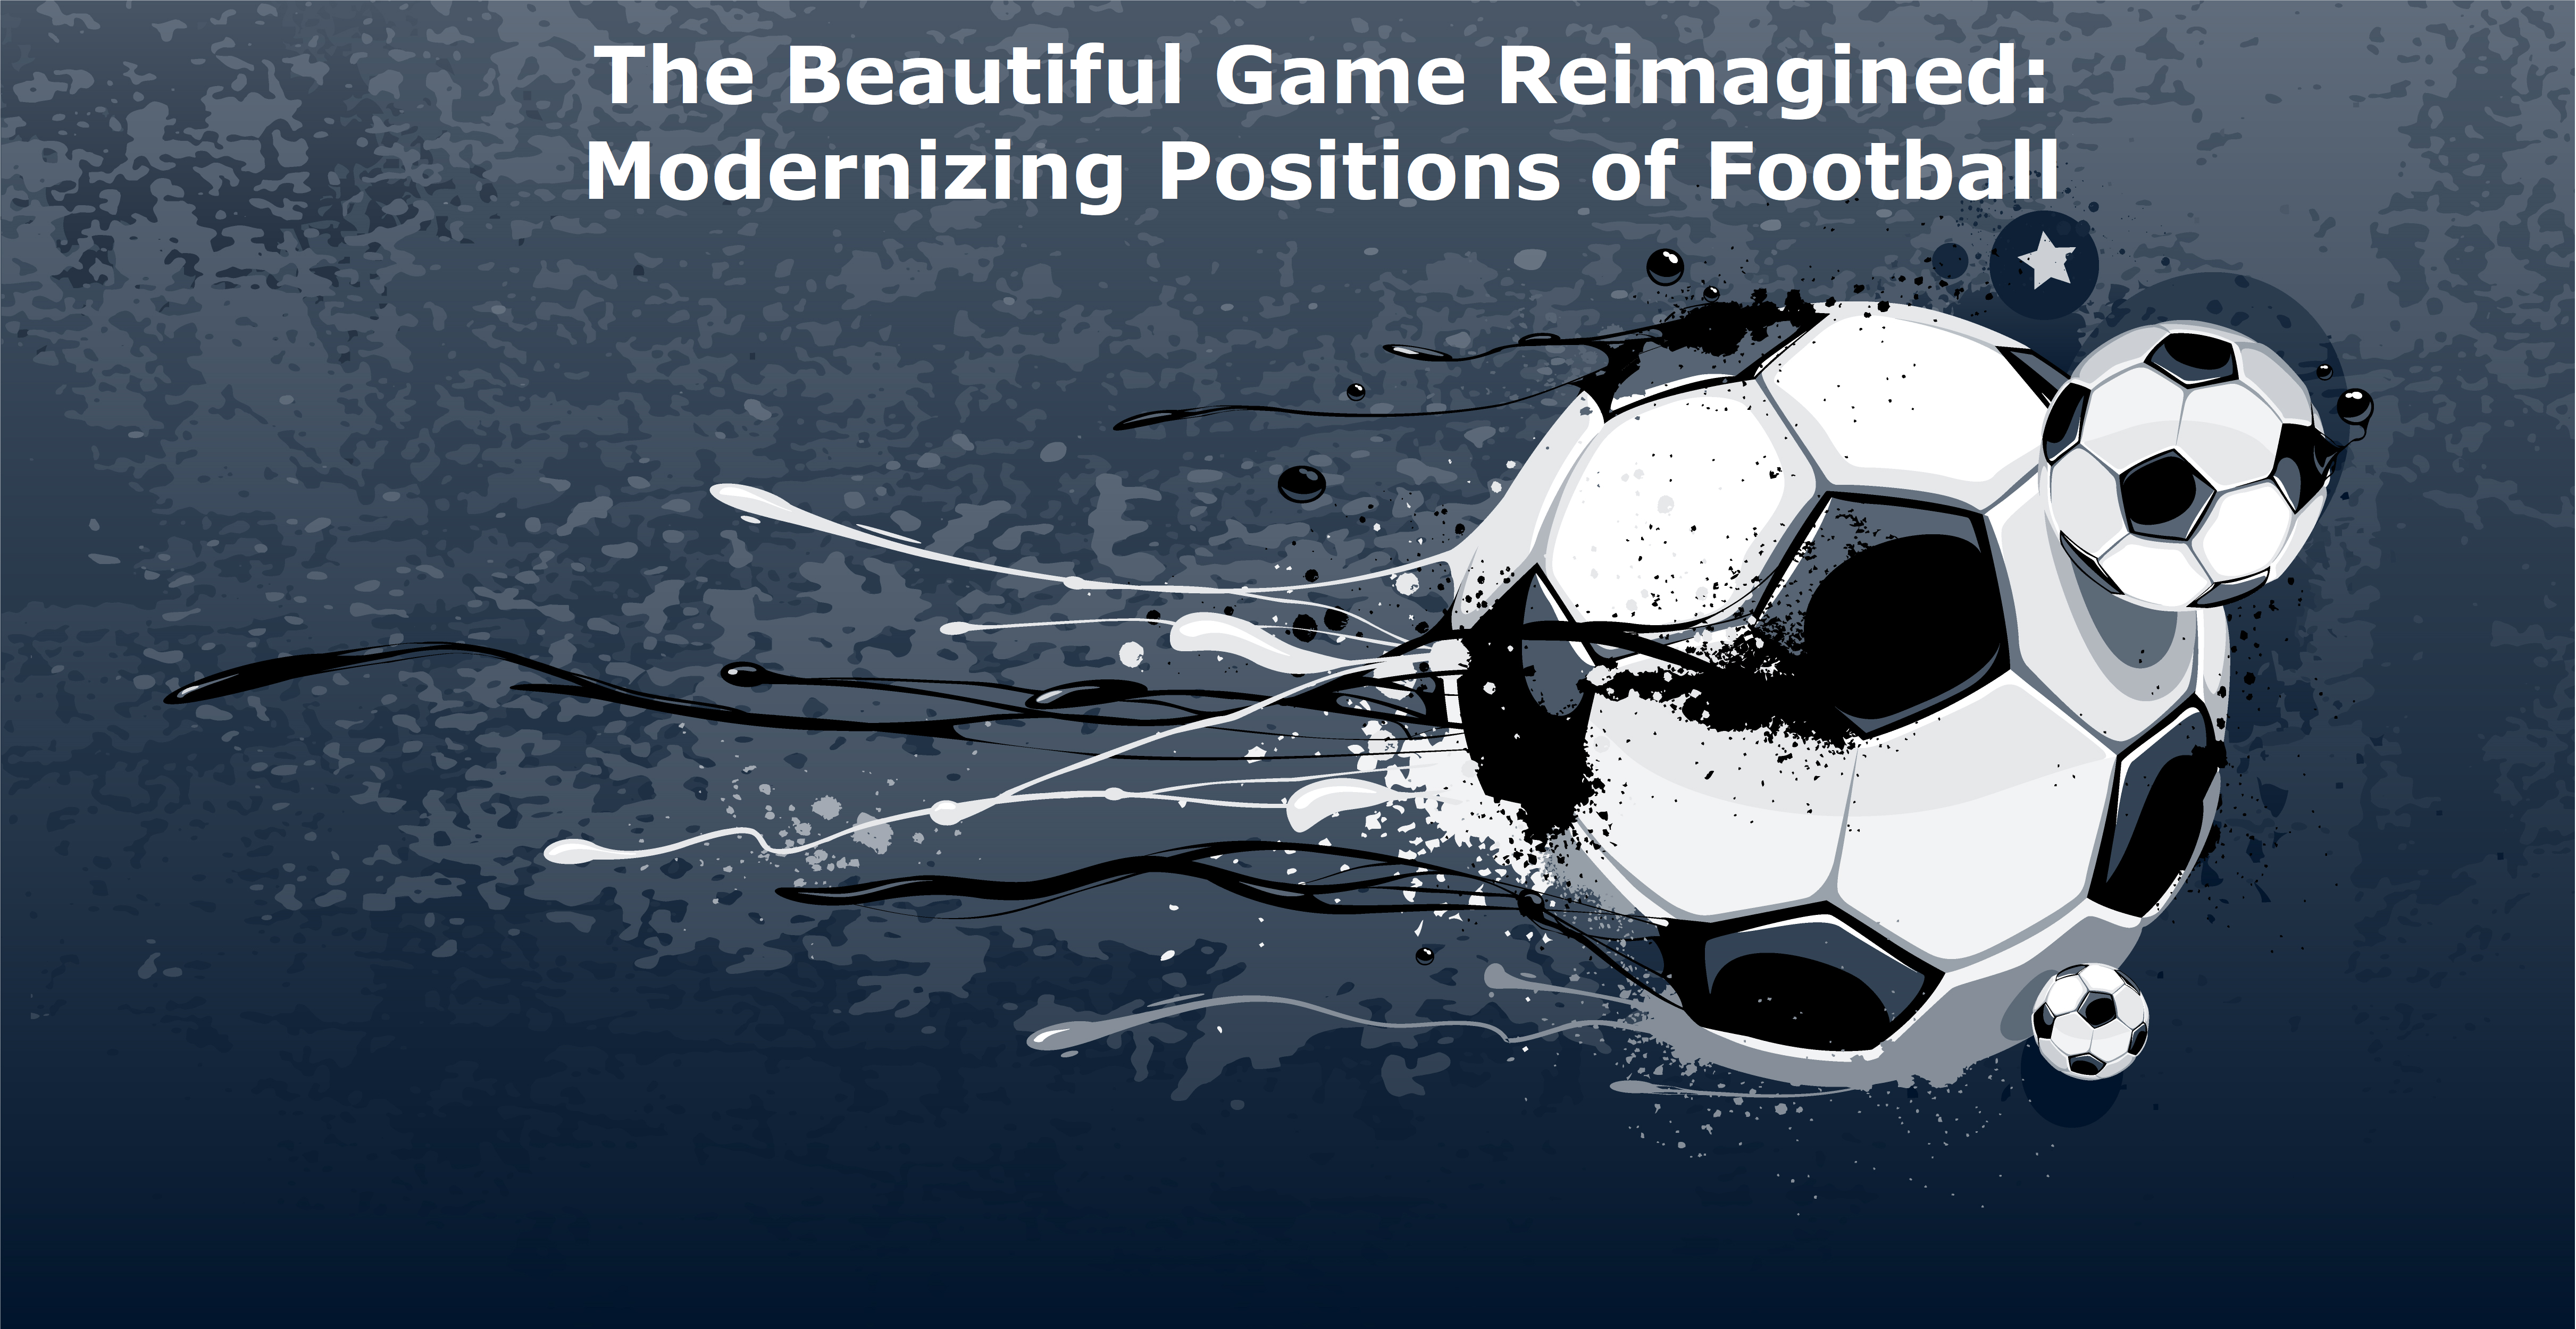

<a id='ExecSum'></a>
<h1 style="color:#FFFFFF; background-color: #324268; border: 1px solid #324268; padding: 10px 0;">Executive Summary</h1>

Football (also known as soccer) has been going through a remarkable evolution in the past years, characterized by various factors that have significantly impacted its pace, tactics, and overall gameplay. This evolution has been driven by advancements in technology, changes in player conditioning and training methods, tactical innovations, and shifts in the rules and regulations governing the sport. As the sport is being redefined over time, so should the way coaches and managers think about the roles of players. 

In this project we wish to redefine the positions and examine their potential future directions using clustering techniques and outlier analysis. In our analysis we found that cluster outliers in general are imporved versions of inliers. In the professional level of football, improvement of physical capabilities start to give diminishing returns. Defenders and goalkeepers are have normalized ratings which means that either the outliers are a mix of high rated and low rated players, or that it takes only a small increase in attributes of defenders and goalkeepers to be an outlier. Lastly, midfielders and forwards should be encouraged to try to make more plays to show off their offensive ratings.

There are a few key assumptions made in this project which includes the parsimoniousness of clusters in our dataset without actually knowing the position distribution of players in our dataset. And as a recommendation, it would be intereseting to perform further analysis on the cluster outliers to see whether their improved stats translate to winning games in football leagues.

<a id='Problem'></a>
<h1 style="color:#FFFFFF; background-color: #324268; border: 1px solid #324268; padding: 10px 0;">Problem Statement</h1>

As the game of football evolves through time, how can we redefine the positions by clustering and outlier analysis to complement the current player's attributes with confidence?

<a id='Motiv'></a>
<h1 style="color:#FFFFFF; background-color: #324268; border: 1px solid #324268; padding: 10px 0;">Motivation</h1>

Soccer or football as called in most countries including Europe, South America, and Asia is an extremely popular sport that is watched by millions of fans globally. Although the sport attracts large audiences, the details and intricacies of the sport remain unclear to some people. It involves two teams of eleven players aiming to score more goals than their opponents. The current position of football revolves around the eleven players which is focused on ensuring that the player is situated in his optimal position. However, limiting a team's player structure based on the eleven or more positions also limits the potential of a team. High number of positions is like a high dimensional data that is very complex and does not always result to a lot of possibilities since the amount of player is not of the same magnitude as compared to data.

Given the evolution of the game as well as the players, it is fitting to redefine the position of current football players accounting for the players' current skill attributes and playstyle. This will open up a lot of creativity in terms of structuring the team as well as for players to be able to have more opportunities and not be limited by their position. The current trend in sports is that players (especially superstars) are becoming a swiss army knife that they can be positioned at multiple roles. This is why looking at the current players and analyzing the patterns and inisights is a necessary task for Football to evolve.

<a id='Source'></a>
<h1 style="color:#FFFFFF; background-color: #324268; border: 1px solid #324268; padding: 10px 0;">Data Source</h1>

<a id='Collect'></a>
<h2 style="color:#324268; background-color: #ffffff; border: 1px solid #ffffff; padding: 10px 0;">Data Description</h2>

**FIFA World Cup Player Ratings**

This dataset contains detailed data related to the FIFA World Cup, including information on players' overall ratings, as well as their individual ratings for specific skillsets. The dataset contains the player attribute information. This part of the database is sourced from the FIFA video game series, which is the best representation of the players' ability in the sport of soccer. This data can be used to investigate a variety of different aspects related to the World Cup and its players, including anomaly detection for player ratings. This dataset is definitely worth taking a look at for those fans of international football, or just interested in studying some of the best athletes in the world.

URL: https://www.kaggle.com/datasets/thedevastator/fifa-world-cup-anomaly-detection-in-player-ratin

**Database Summary:**
- 18,278 players
- 162 countries
- 100+ Players' attributes* sourced from EA Sports' FIFA video game series, including the weekly updates
- Players' position in both National Teams and Professional League Teams
- Players' personal data
- Updated to reflect the 2019-2020 Football Season

**Original Data Source**
This dataset was collected and processed by STEFANO LEONE and 
THE DEVASTATOR from the following sources. 
- http://football-data.mx-api.enetscores.com/ : scores, lineup, team formation and events
- http://www.football-data.co.uk/ : betting odds. Click here to understand the column naming system for betting odds:
- http://sofifa.com/ : players and teams attributes from EA Sports FIFA games. FIFA series and all FIFA assets property of EA Sports.

<a id='Collect'></a>
<h2 style="color:#324268; background-color: #ffffff; border: 1px solid #ffffff; padding: 10px 0;">Data Loading</h2>

<span style="font-size: 16px">
    <center><b>Table 1. Player Ratings Raw Data Description</b><span style="font-size: 10px">[1][2]</span></center> 
</span>
    
|<center>Variable Name</center>|<center>Data type</center>|<center>Variable Caterogy</center>|<center>Description</center>
|:---|:---|:---|:---|
|sofifa_id|integer|ordinal|Unique player FIFA ID
|player_url|string|string|sofifa.com url of the player
|short_name|string|string|Abbreviated name of the player
|long_name|string|string|Complete name of the player
|age|integer|nominal|Age of the player in year 2019
|dob|string|datetime|Date of birth of the player
|height_cm|integer|nominal|Height of the player measured in cm
|weight_kg|integer|nominal|Weight of the player measured in kg
|nationality|string|string|Country of origin of the player
|club|string|string|Professional team the player is rostered in
|overall|integer|nominal|Aggregated rating of the player measured between 1-99
|potential|integer|nominal|Maximum rating expected to be reached by a player rated between 1-99
|value_eur|integer|nominal|Estimated monetary value of the player in Euro
|wage_eur|integer|nominal|Contracted wage of the player in Euro
|player_positions|string|string|List of positions the player can be assigned to
|preferred_foot|string|categorical|Dominant foot of the player which is either right or left
|international_reputation|integer|categorical|Reputation of the player categorized between 1-5
|weak_foot|string|categorical|Non-dominant foot of the player which is either right or left
|skill_moves|integer|categorical|Overall skill of the player categorized between 1-5
|work_rate|string|categorical|Work rate of the player catergorized as Low, Medium, High or combination of the three
|body_type|string|categorical|Body type of the player catergorized as Lean, Normal or based on a specific player
|real_face|string|categorical|Yes if the real face of the player is used in FIFA 20, otherwise No
|release_clause_eur|integer|nominal|Monetary value of the player when released by its club
|player_tags|string|categorical|Skill tags of the player assigned by the FIFA video game
|team_position|string|categorical|Position of the player on its club
|team_jersey_number|integer|nominal|Jersey number representing the player on the club
|loaned_from|string|string|Previous team of the player before transferring to a new team
|joined|string|datetime|Date when the player joined his current club
|contract_valid_until|float|nominal|Year the contract of the player is valid 
|nation_position|string|categorical|Position of the player on the national team
|nation_jersey_number|integer|nominal|Jersey number representing the player on the national team
|pace|integer|nominal|Pacing ability of a player rated between 1-99
|passing|integer|nominal|Overall passing ability of a player rated between 1-99
|shooting|integer|nominal|Overall shooting ability of a player rated between 1-99
|dribbling|integer|nominal|Overall dribbling ability of a player rated between 1-99
|defending|integer|nominal|Overall defending ability of a player rated between 1-99
|physic|integer|nominal|Overall physic of a player rated between 1-99
|gk_diving|integer|nominal|Player's ability to dive as a goalkeeper
|gk_handling|integer|nominal|Player's ability to handle the ball and hold onto it as a goalkeeper
|gk_kicking|integer|nominal|Player's ability to kick the ball as a goalkeeper
|gk_reflexes|integer|nominal|Player's ability and speed to react on the play as a goalkeeper
|gk_speed|integer|nominal|Player's ability to move around quickly as a goalkeeper
|gk_positioning|integer|nominal|How well a player is able to position himself on the field as a goalkeeper
|player_traits|string|string|Detailed description of the player
|attacking_crossing|integer|nominal|The quality and accuracy of a player’s crosses.
|attacking_finishing|integer|nominal|The ability of a player to score.
|attacking_heading_accuracy|integer|nominal|A player’s accuracy when using the head in offense.
|attacking_short_passing|integer|nominal|A player’s accuracy for the short passes.
|attacking_volleys|integer|nominal|The ability of a player to perform volleys.
|skill_dribbling|integer|nominal|A player’s ability to handle the ball while moving.
|skill_curve|integer|nominal|A player’s ability to curve the ball when passing and shooting.
|skill_fk_accuracy|integer|nominal|The accuracy with which a player takes free kicks.
|skill_long_passing|integer|nominal|A player’s accuracy for the long passes.
|skill_ball_control|integer|nominal|A player’s ability to keep possession of the ball.
|movement_acceleration|integer|nominal|The rate at which a player’s running speed increases.
|movement_sprint_speed|integer|nominal|Defines the speed rate of a player’s sprinting.
|movement_agility|integer|nominal|Determines a player’s ability to manage and control the ball quickly and gracefully.
|movement_reactions|integer|nominal|A player’s reaction time in response to events taking place around them.
|movement_balance|integer|nominal|The even distribution of enabling a player to remain upright and keep going.
|power_shot_power|integer|nominal|The strength of a player’s shoots.
|power_jumping|integer|nominal|The ability of a player to jump off the ground for headers.
|power_stamina|integer|nominal|A player’s ability to sustain prolonged physical or mental effort
|power_strength|integer|nominal|The quality or state of being physically strong.
|power_long_shots|integer|nominal|A player’s accuracy for the shots taking from long distances.
|mentality_aggression|integer|nominal|A player’s degree of aggressiveness.
|mentality_interceptions|integer|nominal|The ability of a player to intercept the ball.
|mentality_positioning|integer|nominal|Defines a player’s ability to spot open space and move into good positions that offer an attacking advantage
|mentality_vision|integer|nominal|A player’s mental awareness about his teammates’ positioning, for passing the ball to them.
|mentality_penalties|integer|nominal|A player’s accuracy for taking penalty shots.
|mentality_composure|integer|nominal|A player’s composure throughout the game.
|defending_marking|integer|nominal|The ability of a player to mark an opponent.
|defending_standing_tackle|integer|nominal|The ability of performing standing tackle.
|defending_sliding_tackle|integer|nominal|The ability to pull off a sliding tackle.
|goalkeeping_diving|integer|nominal|Player's ability to dive as a goalkeeper
|goalkeeping_handling|integer|nominal|Player's ability to handle the ball and hold onto it as a goalkeeper
|goalkeeping_kicking|integer|nominal|Player's ability to kick the ball as a goalkeeper
|goalkeeping_positioning|integer|nominal|Player's ability and speed to react on the game as a goalkeeper
|goalkeeping_reflexes|integer|nominal|Player's ability and speed to react on the play as a goalkeeper
|gk_positioning|integer|nominal|How well a player is able to position himself on the field as a goalkeeper
|ls|string|string|Player attribute playing as left striker
|st|string|string|Player attribute playing as striker
|rs|string|string|Player attribute playing as right striker
|lw|string|string|Player attribute playing as left winger
|lf|string|string|Player attribute playing as left forward
|cf|string|string|Player attribute playing as center forward
|rf|string|string|Player attribute playing as right forward
|rw|string|string|Player attribute playing as right winger
|lam|string|string|Player attribute playing as left attacking midfielder
|cam|string|string|Player attribute playing as center attacking midfielder
|ram|string|string|Player attribute playing as right attacking midfielder
|lam|string|string|Player attribute playing as left attacking midfielder
|lm|string|string|Player attribute playing as left midfielder
|lcm|string|string|Player attribute playing as left center midfielder
|cm|string|string|Player attribute playing as center midfielder
|rcm|string|string|Player attribute playing as right center midfielder
|rm|string|string|Player attribute playing as right midfielder
|lwb|string|string|Player attribute playing as left wing backer
|ldm|string|string|Player attribute playing as left defensive midfielder
|cdm|string|string|Player attribute playing as center defensive midfielder
|rdm|string|string|Player attribute playing as right defensive midfielder
|rwb|string|string|Player attribute playing as right wing backer
|ldm|string|string|Player attribute playing as left defensive midfielder
|lb|string|string|Player attribute playing as left backer
|lcb|string|string|Player attribute playing as left center backer
|cb|string|string|Player attribute playing as center backer
|rcb|string|string|Player attribute playing as right center backer
|rb|string|string|Player attribute playing as right backer

In [5]:
df_soccer = pd.read_csv('./players_20.csv')
df_soccer.head()

sofifa_id                                         player_url  \
0     158023  https://sofifa.com/player/158023/lionel-messi/...   
1      20801  https://sofifa.com/player/20801/c-ronaldo-dos-...   
2     190871  https://sofifa.com/player/190871/neymar-da-sil...   
3     200389  https://sofifa.com/player/200389/jan-oblak/20/...   
4     183277  https://sofifa.com/player/183277/eden-hazard/2...   

          short_name                            long_name  age         dob  \
0           L. Messi       Lionel Andrés Messi Cuccittini   32  1987-06-24   
1  Cristiano Ronaldo  Cristiano Ronaldo dos Santos Aveiro   34  1985-02-05   
2          Neymar Jr        Neymar da Silva Santos Junior   27  1992-02-05   
3           J. Oblak                            Jan Oblak   26  1993-01-07   
4          E. Hazard                          Eden Hazard   28  1991-01-07   

   height_cm  weight_kg nationality                 club  ...   lwb   ldm  \
0        170         72   Argentina         FC Barcelona  ...  68+2  66+2   
1        187         83    Portugal             Juventus  ...  65+3  61+3   
2        175         68      Brazil  Paris Saint-Germain  ...  66+3  61+3   
3        188         87    Slovenia      Atlético Madrid  ...   NaN   NaN   
4        175         74     Belgium          Real Madrid  ...  66+3  63+3   

    cdm   rdm   rwb    lb   lcb    cb   rcb    rb  
0  66+2  66+2  68+2  63+2  52+2  52+2  52+2  63+2  
1  61+3  61+3  65+3  61+3  53+3  53+3  53+3  61+3  
2  61+3  61+3  66+3  61+3  46+3  46+3  46+3  61+3  
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4  63+3  63+3  66+3  61+3  49+3  49+3  49+3  61+3  

[5 rows x 104 columns]

<span style="font-size: 12px">
    <center><b>Table 2. Raw Player Rating Dataset</b></center>
</span><br>

<a id='EDA'></a>
<h1 style="color:#FFFFFF; background-color: #324268; border: 1px solid #324268; padding: 10px 0;">Data Exploration</h1>

The raw dataset is analyzed using descriptive exploratory data analysis (EDA) to uncover initial insights to be familiarized on the dataset Another purpose of the EDA is to know which pre-processing techniques will be necessary and which methods will be effective to use on the dataset.  

<span style="font-size: 18px">
    <u>Only <b>56</b> columns do not have any null values</u>
</span>

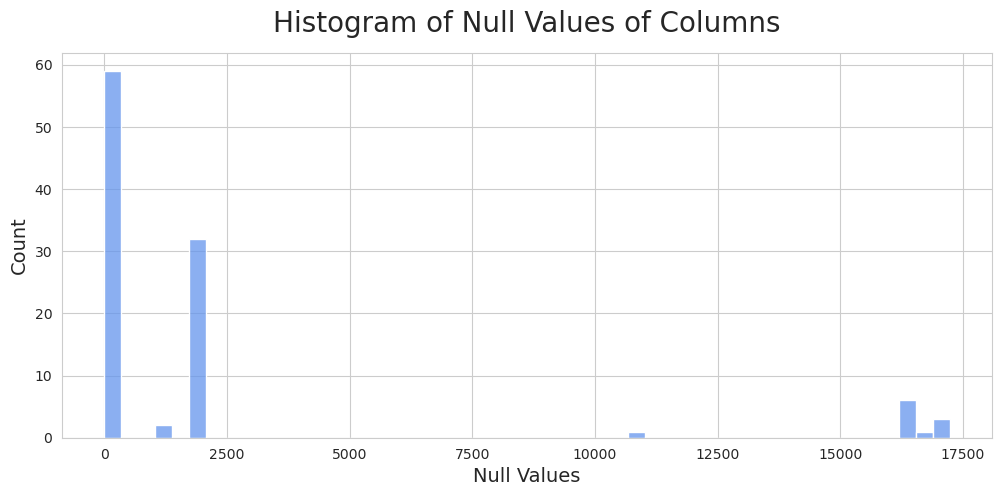

In [6]:
# Get number of null values per column
df_na = df_soccer.isna().sum().reset_index().rename(columns={0: 'null_count'})
df_na = df_na.set_index('index')

col = list(df_na.index)

# Histogram
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.histplot(data=df_na,
                  x='null_count',
                  bins=50,
                  color='cornflowerblue')
 
plt.xlabel("Null Values", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.title("Histogram of Null Values of Columns", fontsize = 20, pad=15);
plt.show()

<span style="font-size: 12px">
    <center><b>Figure 1. Histogram of Null Value Count</b></center>
</span><br>

<span style="font-size: 18px">
    <u>Only <b>2 percent</b> of the players have an overall rating above 80, while <b>16 percent</b> are below 60.</u>
</span>

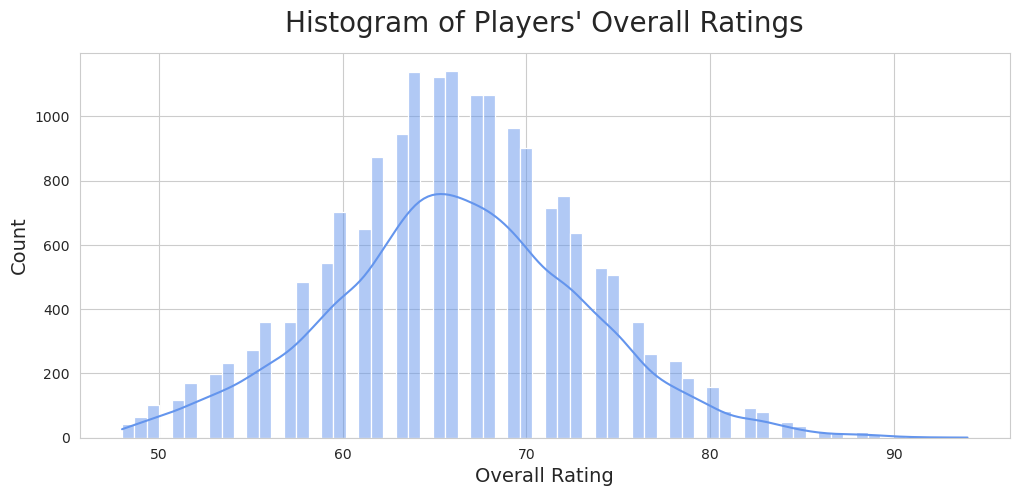

In [7]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.histplot(data=df_soccer,
             x='overall',
             kde=True,
             color='cornflowerblue')
 
plt.xlabel("Overall Rating", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.title("Histogram of Players' Overall Ratings", fontsize = 20, pad=15);
plt.show()

<span style="font-size: 12px">
    <center><b>Figure 2. Histogram of Overall Ratings Count</b></center>
</span><br>

<span style="font-size: 18px">
    <u>The median player age is <b>25 years old</b>. The youngest in the pool is 16 years old while the oldest is 42</u>
</span>

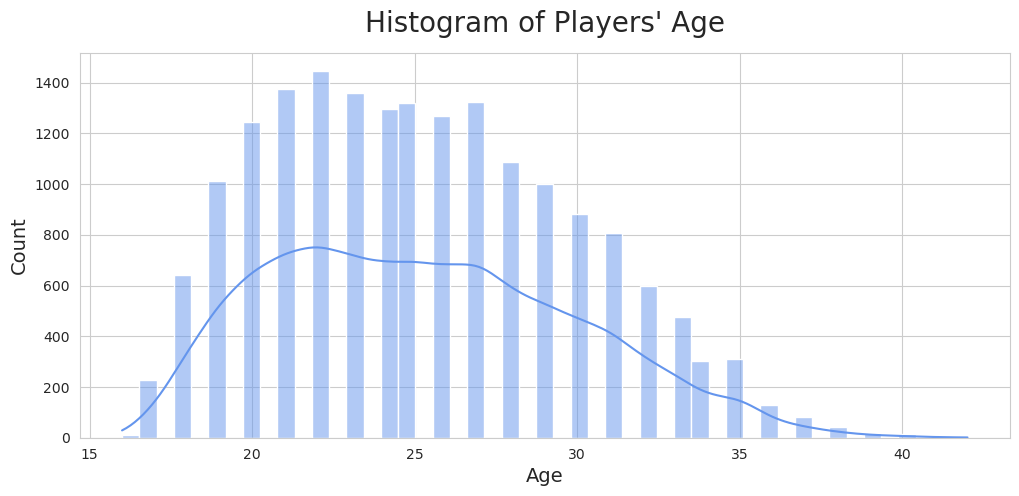

In [8]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.histplot(data=df_soccer,
             x='age',
             kde=True,
             color='cornflowerblue')
 
plt.xlabel("Age", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.title("Histogram of Players' Age", fontsize = 20, pad=15);
plt.show()

<span style="font-size: 12px">
    <center><b>Figure 3. Histogram of Player Age Count</b></center>
</span><br>

<span style="font-size: 18px">
    <u><b>European countries</b> dominate the World Cup roster</u>
</span>

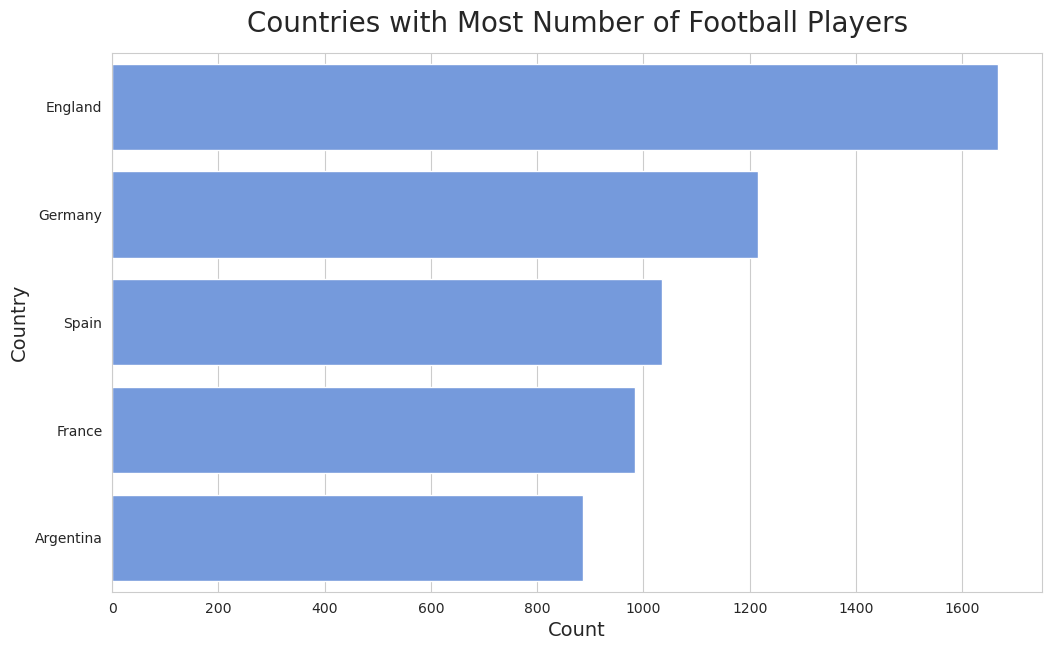

In [9]:
df_natl = (df_soccer.groupby('nationality')['sofifa_id'].count()
                    .reset_index()
                    .sort_values('sofifa_id', ascending=False))


fig, ax = plt.subplots(figsize=(12,7))
ax = sns.barplot(data=df_natl[:5], y='nationality', x='sofifa_id', 
                 color='cornflowerblue', orient='h')

plt.xlabel("Count", fontsize = 14)
plt.ylabel("Country", fontsize = 14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.title("Countries with Most Number of Football Players", fontsize = 20, 
          pad=15);
plt.show()

<span style="font-size: 12px">
    <center><b>Figure 4. Bar Plot of Countries with Most Number of Players</b></center>
</span><br>

<span style="font-size: 18px">
    <u><b>Every position</b> from both offensive and defensive positions is well represented in the dataset</u>
</span>

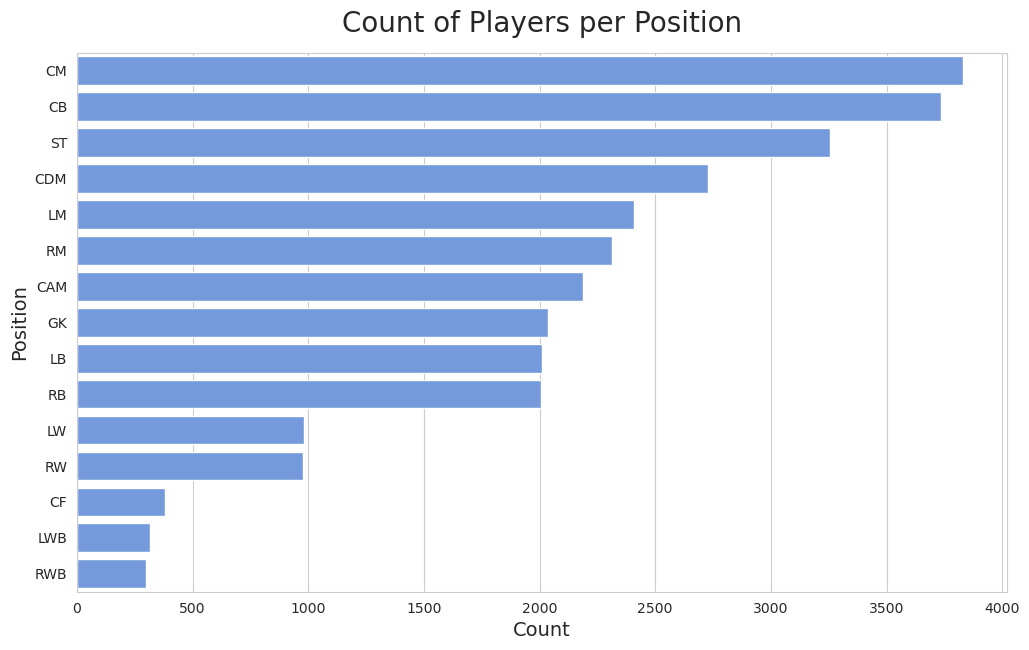

In [10]:
df_player = df_soccer[['sofifa_id', 'short_name', 
                       'overall', 'player_positions']]

col = df_player.columns
lst_col = 'player_positions'
x = df_player.assign(**{lst_col:df_player[lst_col].str.split(', ')})

df_pos = (pd.DataFrame({col:np.repeat(x[col].values, x[lst_col].str.len())
                        for col in x.columns.difference([lst_col])})
                      .assign(**{lst_col:np.concatenate(x[lst_col].values)})
                      [x.columns.tolist()])

df_position = (df_pos.groupby(lst_col)['overall'].count()
               .reset_index()
               .sort_values('overall', ascending=False))

fig, ax = plt.subplots(figsize=(12,7))
ax = sns.barplot(data=df_position, y=lst_col, x='overall', 
                 color='cornflowerblue', orient='h')

plt.xlabel("Count", fontsize = 14)
plt.ylabel("Position", fontsize = 14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.title("Count of Players per Position", fontsize = 20, pad=15);

<span style="font-size: 12px">
    <center><b>Figure 5. Bar Plot of Players' Position Count</b></center>
</span><br>

<a id='Methodology'></a>
<h1 style="color:#FFFFFF; background-color: #324268; border: 1px solid #324268; padding: 10px 0;">Methodology</h1>

<span style="font-size: 16px">
    <center><b>Table 3. Methodology Details</b></center> 
</span>

<table >
    <tr style="color:#FFFFFF; font-size:16px; background-color:#324268">
        <th style="text-align: center">Journey</th>
        <th style="text-align: center">Task</th>
        <th style="text-align: center">Steps</th>
    </tr>
    <tr>
        <td style="color:#324268; font-size:14px; font-weight:bold; text-align: left">PREPARE</td>
        <td style="text-align: left; font-size:14px; font-weight:bold; color:#000080;">Data Cleaning and Pre-Processing</td>
        <td style="font-size:13px; text-align: left"><ul>
            <li>Filter and select columns that will be analyzed from the original dataset.</li>
            <li>Perform null value imputation per column.</li>
            <li>Perform removal of duplicate data.</li>
            </ul></td>
    </tr>
    <tr>
        <td style="color:#324268; font-size:14px; font-weight:bold; text-align: left">EXPLORE</td>
        <td style="text-align: left; font-size:14px; font-weight:bold; color:#000080;">Exploratory Data Analysis</td>
        <td style="font-size:13px; text-align: left"><ul>
            <li>Create visualizations that summarizes the data.</li>
            <li>Discover correlations and relationships between variables in your data.</li>
            </ul></td>
    </tr>
     <tr>
        <td style="color:#324268; font-size:14px; font-weight:bold; text-align: left">GROUP</td>
        <td style="text-align: left; font-size:14px; font-weight:bold; color:#000080;">Clustering</td>
        <td style="font-size:13px; text-align: left"><ul>
            <li>Test different clustering models on the dataset</li>
            <li>Evaluate results given a set of metrics</li>
            <li>Select best model then generate insights</li>
            </ul></td>
    </tr>
    <tr>
        <td style="color:#324268; font-size:14px; font-weight:bold; text-align: left">NORMALIZE</td>
        <td style="text-align: left; font-size:14px; font-weight:bold; color:#000080;">Outlier Analysis</td>
        <td style="font-size:13px; text-align: left"><ul>
            <li>Test different outlier analysis models on the dataset for each cluster</li>
            <li>Evaluate results given a set of metrics</li>
            <li>Select best model then generate insights</li>
            </ul></td>
    </tr>
    <tr>
        <td style="color:#324268; font-size:14px; font-weight:bold; text-align: left">UNCOVER</td>
         <td style="text-align: left; font-size:14px; font-weight:bold; color:#000080;">Generate Insights</td>
        <td style="font-size:13px; text-align: left"><ul>
            <li>Interpret results of the clustering and outlier analysis</li>
            <li>Provide use cases that are applicable to the data.</li>
            </ul></td>
    </tr>
</table>
<br>

<a id='Clean'></a>
<h2 style="color:#324268; background-color: #ffffff; border: 1px solid #ffffff; padding: 10px 0;">Data Cleaning and Pre-processing</h2>

In order to arrive at the final dataset to be used for analysis, the following steps were taken:

1. Filter columns related to numerical skill attributes and numerical physical traits of the players.
2. Filter attributes with null values.
3. Onehot encode the preferred foot and drop the first column of the resulting columns.
3. Sort columns so that the the physical traits are ordered first before the skill ratings.
4. Set index of the dataset to `sofifa_id`.

<span style="font-size: 16px">
    <center><b>Table 4. Player Attributes Final Data Description</b></center>
</span>
    
|<center>Variable Name</center>|<center>Data type</center>|<center>Variable Caterogy</center>|<center>Description</center>
|:---|:---|:---|:---|
|sofifa_id|integer|ordinal|Unique player FIFA ID
|age|integer|nominal|Age of the player in year 2019
|height_cm|integer|nominal|Height of the player measured in cm
|weight_kg|integer|nominal|Weight of the player measured in kg
|preferred_foot|integer|categorical|Dominant foot of the player (0 for Left, 1 for Right)
|attacking_crossing|integer|nominal|The quality and accuracy of a player’s crosses.
|attacking_finishing|integer|nominal|The ability of a player to score.
|attacking_heading_accuracy|integer|nominal|A player’s accuracy when using the head in offense.
|attacking_short_passing|integer|nominal|A player’s accuracy for the short passes.
|attacking_volleys|integer|nominal|The ability of a player to perform volleys.
|skill_dribbling|integer|nominal|A player’s ability to handle the ball while moving.
|skill_curve|integer|nominal|A player’s ability to curve the ball when passing and shooting.
|skill_fk_accuracy|integer|nominal|The accuracy with which a player takes free kicks.
|skill_long_passing|integer|nominal|A player’s accuracy for the long passes.
|skill_ball_control|integer|nominal|A player’s ability to keep possession of the ball.
|movement_acceleration|integer|nominal|The rate at which a player’s running speed increases.
|movement_sprint_speed|integer|nominal|Defines the speed rate of a player’s sprinting.
|movement_agility|integer|nominal|Determines a player’s ability to manage and control the ball quickly and gracefully.
|movement_reactions|integer|nominal|A player’s reaction time in response to events taking place around them.
|movement_balance|integer|nominal|The even distribution of enabling a player to remain upright and keep going.
|power_shot_power|integer|nominal|The strength of a player’s shoots.
|power_jumping|integer|nominal|The ability of a player to jump off the ground for headers.
|power_stamina|integer|nominal|A player’s ability to sustain prolonged physical or mental effort
|power_strength|integer|nominal|The quality or state of being physically strong.
|power_long_shots|integer|nominal|A player’s accuracy for the shots taking from long distances.
|mentality_aggression|integer|nominal|A player’s degree of aggressiveness.
|mentality_interceptions|integer|nominal|The ability of a player to intercept the ball.
|mentality_positioning|integer|nominal|Defines a player’s ability to spot open space and move into good positions that offer an attacking advantage
|mentality_vision|integer|nominal|A player’s mental awareness about his teammates’ positioning, for passing the ball to them.
|mentality_penalties|integer|nominal|A player’s accuracy for taking penalty shots.
|mentality_composure|integer|nominal|A player’s composure throughout the game.
|defending_marking|integer|nominal|The ability of a player to mark an opponent.
|defending_standing_tackle|integer|nominal|The ability of performing standing tackle.
|defending_sliding_tackle|integer|nominal|The ability to pull off a sliding tackle.
|goalkeeping_diving|integer|nominal|Player's ability to dive as a goalkeeper
|goalkeeping_handling|integer|nominal|Player's ability to handle the ball and hold onto it as a goalkeeper
|goalkeeping_kicking|integer|nominal|Player's ability to kick the ball as a goalkeeper
|goalkeeping_positioning|integer|nominal|Player's ability and speed to react on the game as a goalkeeper
|goalkeeping_positioning|integer|nominal|How well a player is able to position himself on the field as a goalkeeper
|goalkeeping_reflexes|integer|nominal|Player's ability and speed to react on the play as a goalkeeper

In [11]:
cols = ['sofifa_id', 'age', 'height_cm', 'weight_kg', 
        'preferred_foot', 'attacking_crossing', 'attacking_finishing', 
        'attacking_heading_accuracy', 'attacking_short_passing', 
        'attacking_volleys', 'skill_dribbling', 'skill_curve', 
        'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 
        'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 
        'movement_reactions', 'movement_balance', 'power_shot_power', 
        'power_jumping', 'power_stamina', 'power_strength', 
        'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 
        'mentality_positioning', 'mentality_vision', 'mentality_penalties', 
        'mentality_composure', 'defending_marking', 
        'defending_standing_tackle', 'defending_sliding_tackle', 
        'goalkeeping_diving', 'goalkeeping_handling', 
        'goalkeeping_kicking', 'goalkeeping_positioning', 
        'goalkeeping_reflexes']

df_soccer_cluster = (df_soccer[cols].set_index('sofifa_id'))
df_soccer_cluster.head()

df_soccer_cluster = (pd.get_dummies(df_soccer_cluster, drop_first=True, 
                                   columns=['preferred_foot'])
                .rename(columns={'preferred_foot_Right':'preferred_foot'}))
df_soccer_final = df_soccer_cluster[cols[1:]]
df_soccer_final.head()

age  height_cm  weight_kg  preferred_foot  attacking_crossing  \
sofifa_id                                                                  
158023      32        170         72               0                  88   
20801       34        187         83               1                  84   
190871      27        175         68               1                  87   
200389      26        188         87               1                  13   
183277      28        175         74               1                  81   

           attacking_finishing  attacking_heading_accuracy  \
sofifa_id                                                    
158023                      95                          70   
20801                       94                          89   
190871                      87                          62   
200389                      11                          15   
183277                      84                          61   

           attacking_short_passing  attacking_volleys  skill_dribbling  ...  \
sofifa_id                                                               ...   
158023                          92                 88               97  ...   
20801                           83                 87               89  ...   
190871                          87                 87               96  ...   
200389                          43                 13               12  ...   
183277                          89                 83               95  ...   

           mentality_penalties  mentality_composure  defending_marking  \
sofifa_id                                                                
158023                      75                   96                 33   
20801                       85                   95                 28   
190871                      90                   94                 27   
200389                      11                   68                 27   
183277                      88                   91                 34   

           defending_standing_tackle  defending_sliding_tackle  \
sofifa_id                                                        
158023                            37                        26   
20801                             32                        24   
190871                            26                        29   
200389                            12                        18   
183277                            27                        22   

           goalkeeping_diving  goalkeeping_handling  goalkeeping_kicking  \
sofifa_id                                                                  
158023                      6                    11                   15   
20801                       7                    11                   15   
190871                      9                     9                   15   
200389                     87                    92                   78   
183277                     11                    12                    6   

           goalkeeping_positioning  goalkeeping_reflexes  
sofifa_id                                                 
158023                          14                     8  
20801                           14                    11  
190871                          15                    11  
200389                          90                    89  
183277                           8                     8  

[5 rows x 38 columns]

<span style="font-size: 12px">
    <center><b>Table 5. Final Player Ratings Dataset</b></center>
</span><br>

<a id='Dimensionality Reduction'></a>
<h2 style="color:#324268; background-color: #ffffff; border: 1px solid #ffffff; padding: 10px 0;">Dimensionality Reduction</h2>

**Dimensionality Reduction** is a critical step in data processing primarily aimed at simplifying the dataset structure. The process reduces the number of features in a dataset to achieve several goals. It minimizes the risk of overfitting by reducing the model's complexity and improves computational efficiency by accelerating the training and testing times of machine learning models. The process can also enhance data visualization, particularly by reducing dimensions, thereby allowing patterns or clusters within the data to become apparent. Moreover, dimensionality reduction improves model performance by mitigating the curse of dimensionality, which refers to the challenge models face when learning from a dataset with too many features. Finally, it serves to eliminate redundant or correlated features, leading to a more effective and efficient learning process. <span style="font-size: 10px">[3]</span>

`Singular Vector Decomposition` (SVD) is applied to this problem since **SVD does not require data to be centered around the mean**, unlike using Principal Component Analysis (PCA). This makes it more flexible and robust, especially when dealing with sparse data. Moreover, SVD can operate directly on the data matrix, whereas PCA works on the covariance matrix, which could be computationally expensive for high-dimensional data. Lastly, SVD provides the singular vectors for both the observations and the variables, which can be more informative for interpretation.

In [12]:
X_soccer_unscaled = df_soccer_final.copy()

# Scaling Dataset

standard_scaler = StandardScaler()
X_soccer = standard_scaler.fit_transform(X_soccer_unscaled)

# DR with SVD

svd = TruncatedSVD(n_components=38, random_state=1337)
X_new_svd = svd.fit_transform(X_soccer)
variance_explained_svd = svd.explained_variance_ratio_
p_svd = svd.components_

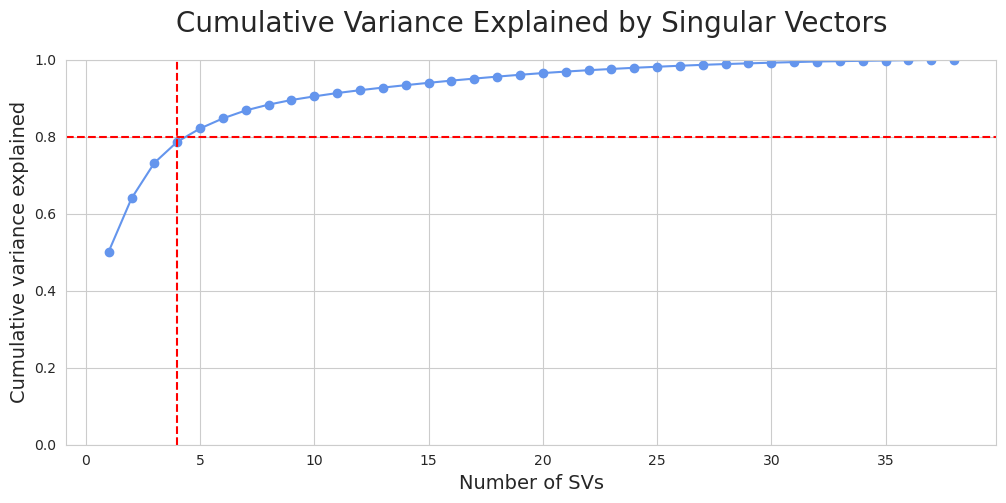

In [13]:
fig, ax = plt.subplots(figsize=(12, 5))
plt.plot(range(1, len(variance_explained_svd)+1), 
         variance_explained_svd.cumsum(), 'o-', c='cornflowerblue')
plt.ylim(0,1)

plt.axhline(y = 0.8, color = 'r', linestyle = '--')
plt.axvline(x = np.where(variance_explained_svd.cumsum() > 0.81)[0][0], 
            color = 'r', linestyle = '--');

plt.xlabel('Number of SVs', fontsize = 14)
plt.ylabel('Cumulative variance explained', fontsize = 14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.title("Cumulative Variance Explained by Singular Vectors", fontsize = 20,
         pad=20);

<span style="font-size: 12px">
    <center><b>Figure 6. Cumulative Variance per Retained Singular Vectors (SV)</b></center>
</span><br>

`Variance explained` pertains to the proportion of the dataset's total variance that is captured by each component derived from the dimensionality reduction process. In order to maximize the amount of information to be retained while maximizing the number of dimensions to be reduced, it is determined to have **at least 80% of the cumulative variance**. This results to only having **4 Singular Vectors** to be retained.

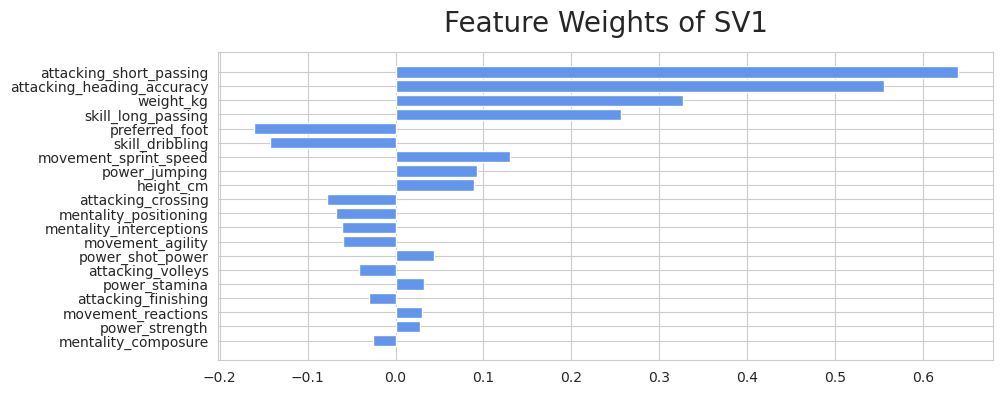

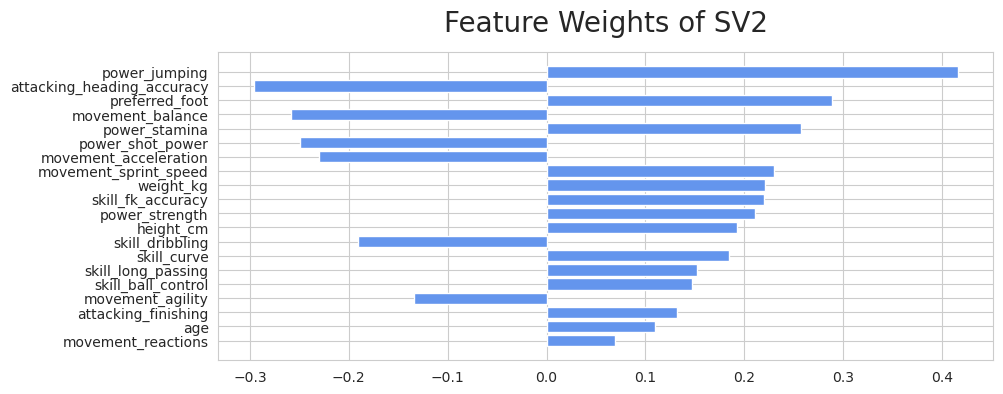

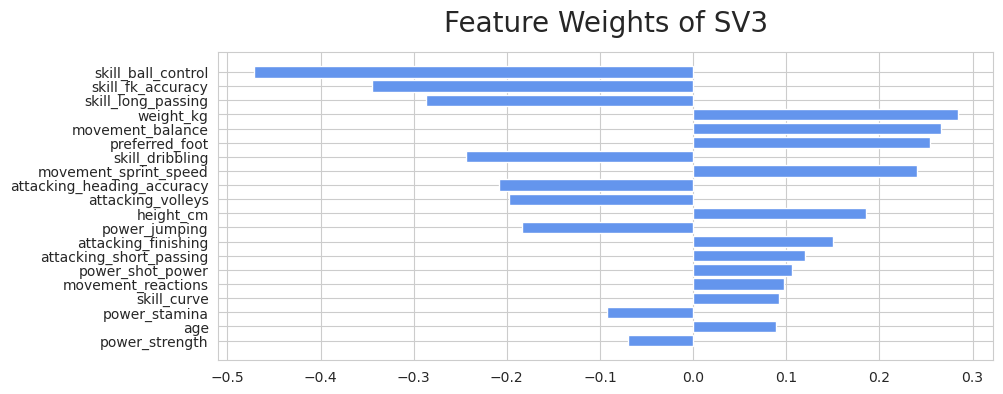

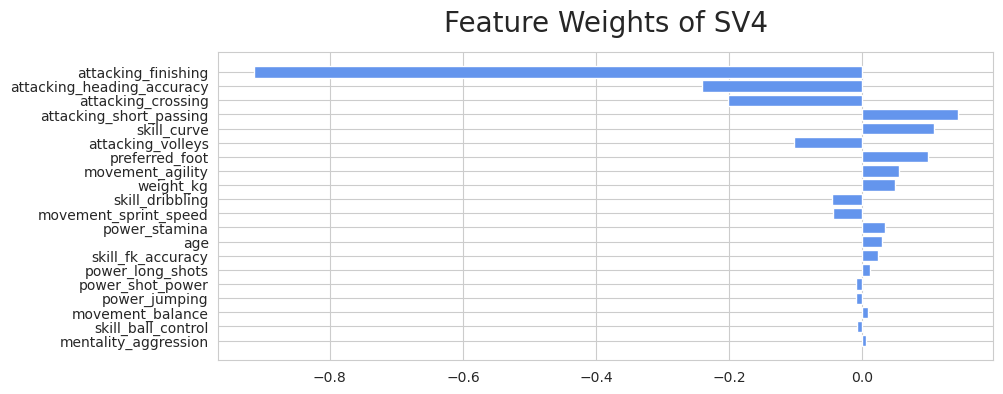

In [14]:
feature_names = df_soccer_final.columns
for i in range(4):
    fig, ax = plt.subplots(figsize=(10, 4))
    order = np.argsort(np.abs(p_svd[:, i]))[-20:]
    ax.barh([feature_names[o] for o in order], p_svd[order, i], 
            color='cornflowerblue')
    ax.set_title(f'Feature Weights of SV{i+1}', fontsize=20, pad=15)

<span style="font-size: 12px">
    <center><b>Figure 7. Feature Weights of the Retained Singular Vectors</b></center>
</span><br>

The feature weights of the four retained SVs are shown in order to show how the original features of the dataset are explained in the SVs. This is helpful especially when intrepreting the resuts of the succeeding methods that will be performed. 

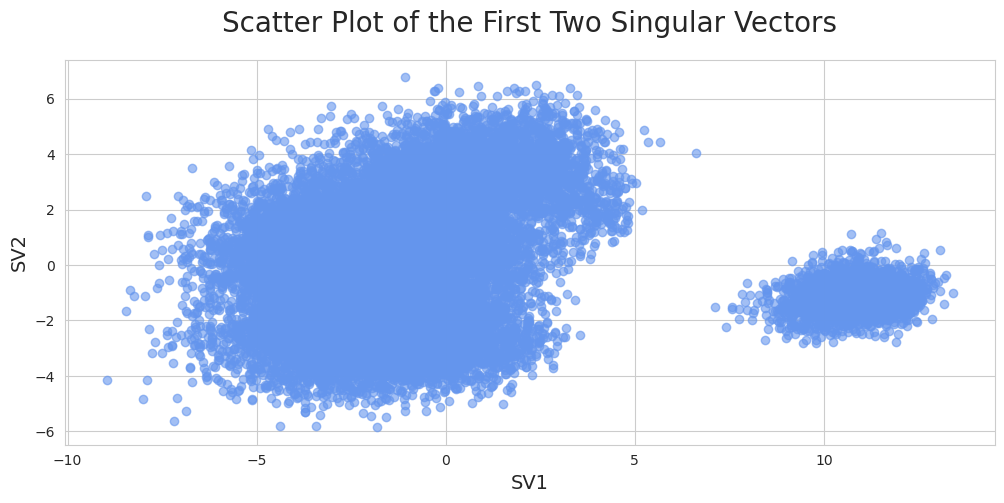

In [15]:
# Current Working Dataset
n_component = np.where(variance_explained_svd.cumsum() > 0.81)[0][0]

svd = TruncatedSVD(n_components=n_component, random_state=1337)
X_new_svd = svd.fit_transform(X_soccer)
fig, ax = plt.subplots(figsize=(12, 5))
plt.scatter(X_new_svd[:,0], X_new_svd[:,1], c='cornflowerblue', alpha=0.6)

plt.xlabel('SV1', fontsize = 14)
plt.ylabel('SV2', fontsize = 14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.title("Scatter Plot of the First Two Singular Vectors", fontsize = 20,
         pad=20);

<span style="font-size: 12px">
    <center><b>Figure 8. Player Ratings Project to the First Two Singular Vectors</b></center>
</span><br>

Visualizing the dataset through the two SVs, it can be observed that there are two clusters that are already formed. However, there are a lot of factors to consider when choosing what is the optimal number of clusters for a specific dataset. 

<a id='Clustering'></a>
<h2 style="color:#324268; background-color: #ffffff; border: 1px solid #ffffff; padding: 10px 0;">Clustering</h2>

**Clustering** is a crucial technique in data analysis and machine learning that serves to identify structure or patterns in a dataset. By grouping data points based on their similarity, clustering provides insights on the natural grouping or segmentation within the data. It is often used for exploratory data analysis to gain insights into the data's distribution and uncover hidden patterns. This can be especially helpful when dealing with large datasets where visual inspection is not feasible. In addition, clustering can also serve as a preprocessing step for other machine learning tasks to create meaningful features, reduce dimensionality, or improve model performance. Clustering plays a pivotal role in helping extract value and actionable insights from raw, unlabeled data. <span style="font-size: 10px">[4]</span>

In this report, two clustering methods will be performed and compared: `Gaussian Mixture Model` (GMM) and `Spectral Clustering`. Both methods will be optimized and iterated for the number of clusters from two to seven. Next is evaluating the results of the cluster which will be done by using and analyzing three metrics: `Silhoutte score`, `Calinski-Harabaz score` (CH), and `Davies-Boulding score` (DB).

The `Silhouette score` is a measure for evaluating how well each data point fits into its assigned cluster, **ranging from -1 (poorly clustered) to +1 (well clustered)**. The score is based on two factors: the mean distance between a data point and all other points in the same cluster (cohesion), and the mean distance between a data point and all other points in the nearest cluster (separation). A higher silhouette score indicates that the data point is well matched to its own cluster and poorly matched to neighboring clusters. If most data points have a high silhouette score, then the clustering configuration is appropriate. If many data points have a low or negative score, then the clustering configuration may have too many or too few clusters.

The `Calinski-Harabaz score`, also known as the Variance Ratio Criterion, is the ratio of the between-clusters dispersion mean and the within-cluster dispersion mean. A **higher Calinski-Harabaz score indicates that the clusters are dense and well separated**, which relates to a model with better defined clusters. Unlike the silhouette score, the Calinski-Harabaz score does not involve computation for every data point, making it more efficient for large datasets. This score works well for datasets with convex clusters.

The `Davies-Bouldin` score evaluates the average 'similarity' between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves. A **lower Davies-Bouldin score signifies that the clusters are less similar to each other** which means they are better separated, compact, and overall a better clustering. It is noteworthy that unlike other metrics, the Davies-Bouldin score aims for a lower value for optimal clustering. This score also works well for datasets with convex clusters. <span style="font-size: 10px">[5]</span>

After the evaluation, the best cluster for the two methods will be compared to select the optimal cluster for this report.

<a id='GMM'></a>
<h3 style="color:#324268; background-color: #ffffff; border: 1px solid #ffffff; padding: 10px 0;">Gaussian Mixture Model</h3>

A `Gaussian Mixture Model` (GMM) is a probabilistic model for clustering that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions, each characterized by their own set of parameters (mean and covariance). Unlike other clustering algorithms like K-means, which assign each data point to a single cluster, GMM allows for soft clustering, meaning that each data point belongs to each cluster to a certain degree. This degree is determined by the probability of the data point being generated from the Gaussian distribution of the cluster. GMMs can also model complex cluster shapes due to their flexibility in the shape of the distribution. <span style="font-size: 10px">[5]</span>

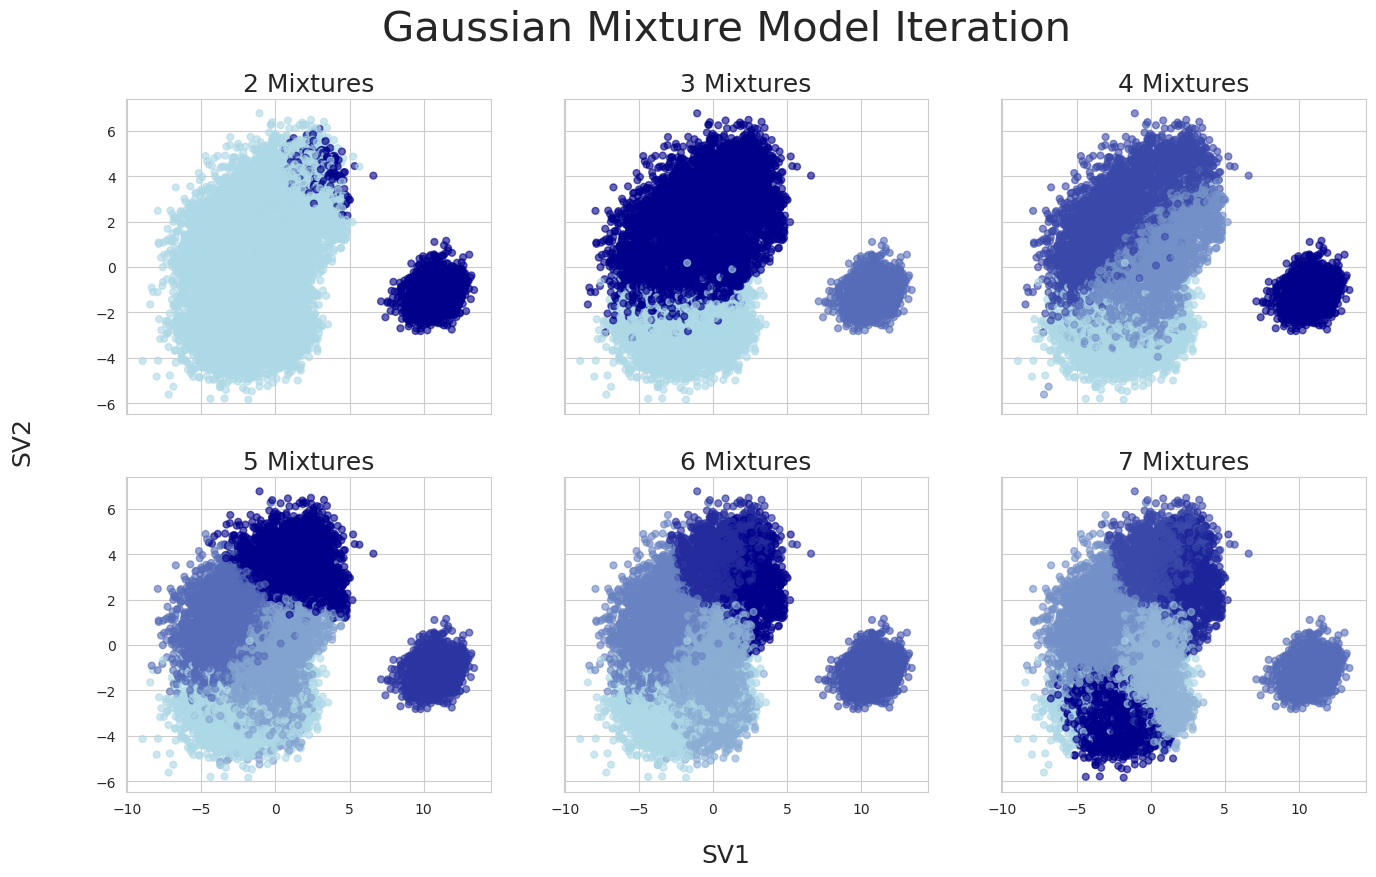

In [16]:
cost = range(2, 8)
fig, ax = plt.subplots(2, len(cost)//2, dpi=100, sharex=True, sharey=True, 
                           figsize=(16,9))
fig.suptitle("Gaussian Mixture Model Iteration", fontsize=30)
fig.text(0.5, 0.04, 'SV1', ha='center', 
         va='center', fontsize=18)
fig.text(0.06, 0.5, 'SV2', ha='center', va='center', 
         rotation='vertical', fontsize=18)

df_val_gmm = pd.DataFrame(index=['silhouette', 'calinski_harabaz', 
                             'davies_bouldin'])

for index, t in enumerate(cost):
    y_predict_soccer = GMM(n_components=t,
                            init_params='k-means++',
                            covariance_type='full',
                            tol=1e-2,
                            max_iter=100,
                           random_state = 143,
                            n_init=1).fit_predict(X_new_svd)
    df_val_gmm[t] = internalValidation(X_new_svd, y_predict_soccer)
    if index < (len(cost)//2):
        ax[0][index].scatter(X_new_svd[:,0], X_new_svd[:,1],
                             c=y_predict_soccer, s=24, alpha=0.6,
                             cmap=cmap)
        ax[0][index].set_title(f'{t} Mixtures', size=18)
    else:
        ax[1][index-len(cost)//2].scatter(X_new_svd[:,0], X_new_svd[:,1],
                                          c=y_predict_soccer, s=24,
                                          alpha=0.6, cmap=cmap)
        ax[1][index-len(cost)//2].set_title(f'{t} Mixtures', size=18)
        


<span style="font-size: 12px">
    <center><b>Figure 9. Gaussian Mixture Model Iteration</b></center>
</span><br>

The visual inspection of the GMM indicates that three clusters is the best model. This is due to having a balance of point less overlaps between the clusters when compared to two clusters. Three clusters is also more parsimonious when compared to other clusters with more than three groupings despite them having more balance between the data points in each cluster.

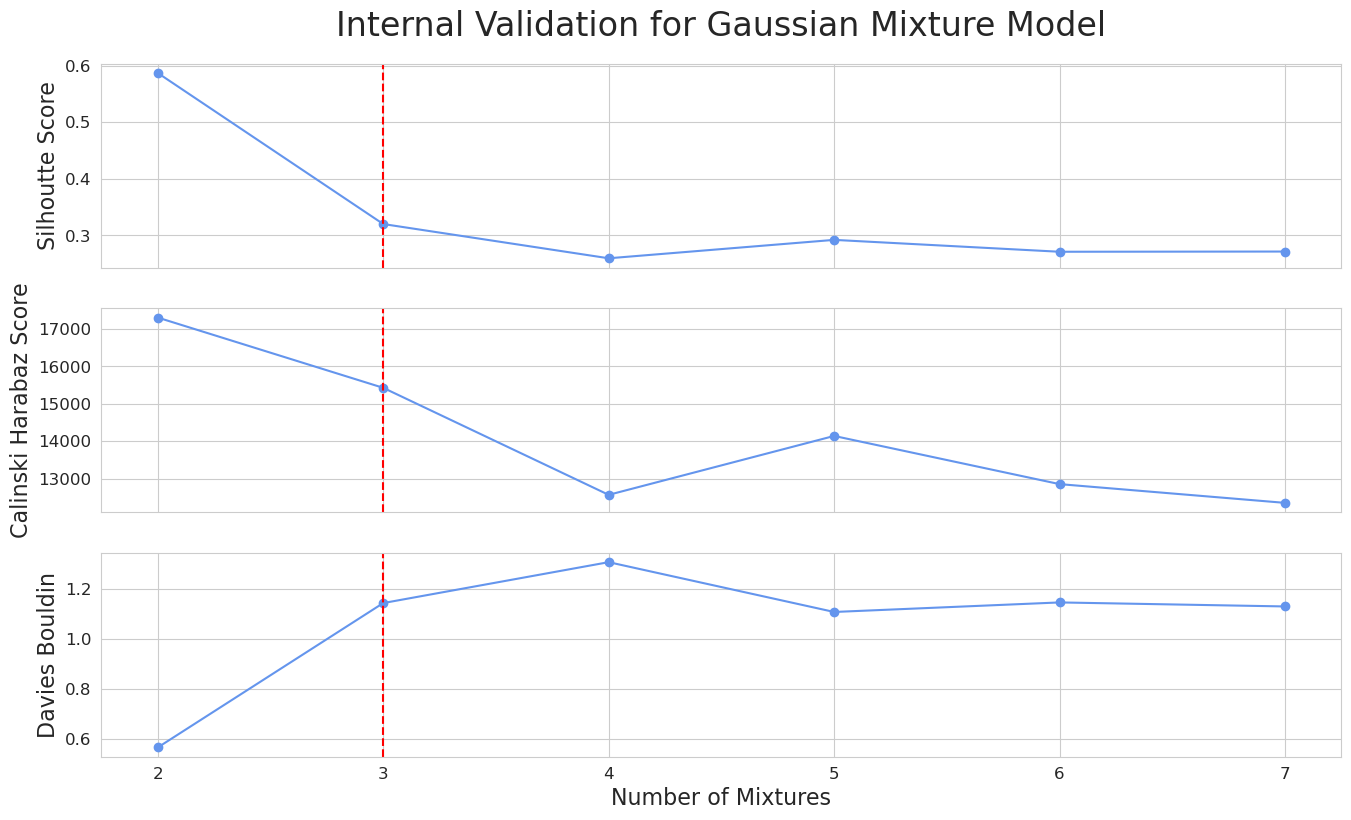

In [17]:
fig, ax = plt.subplots(3, 1, dpi=100, sharex=True, figsize=(16,9))

df_val_gplot = df_val_gmm.T

ax[0].set_title("Internal Validation for Gaussian Mixture Model", 
                fontsize = 24,pad=20);

ax[0].plot(df_val_gplot[[df_val_gplot.columns[0]]], 'o-', c='cornflowerblue')
ax[0].set_ylabel('Silhoutte Score', fontsize = 16)
ax[0].axvline(x=3, color='r', linestyle='--');
ax[0].tick_params(axis='both', which='major', labelsize=12)

ax[1].plot(df_val_gplot[[df_val_gplot.columns[1]]], 'o-', c='cornflowerblue')
ax[1].set_ylabel('Calinski Harabaz Score', fontsize = 16)
ax[1].axvline(x=3, color='r', linestyle='--');
ax[1].tick_params(axis='both', which='major', labelsize=12)

ax[2].plot(df_val_gplot[[df_val_gplot.columns[2]]], 'o-', c='cornflowerblue')
ax[2].set_ylabel('Davies Bouldin', fontsize = 16)
ax[2].axvline(x=3, color='r', linestyle='--');
ax[2].tick_params(axis='both', which='major', labelsize=12)

plt.xlabel('Number of Mixtures', fontsize = 16)
plt.show()

<span style="font-size: 12px">
    <center><b>Figure 10. Internal Validation Metrics of the GMM Iterations</b></center>
</span><br>

Based on the results of the scatter plot of clusters and the evaluation plots, two clusters can be safely chosen. Two clusters have the separated cluster, closest to one Silhoutte score, highest CH score, and nearest to 0 DB score. However, if the features of the two clusters are checked, it can be observed that the resulting clusters are the goal keepers and non-goal keepers since one of the clusters (the more compact one) will have notably high goal keeping attributes and the other cluster will have low goal keeping skills. This is not ideal for looking at the positions since the game of football requires more than identifying the goal keepers from non-goal keepers. There is also the issue of high imbalance in the number of points per cluster. This is why the **optimal number of cluster chosen in the GMM method is three clusters** which is more balanced in terms of the number of points per cluster as well as good results in the three metrics.



<a id='SC'></a>
<h3 style="color:#324268; background-color: #ffffff; border: 1px solid #ffffff; padding: 10px 0;">Spectral Clustering</h3>

`Spectral Clustering`, on the other hand, is a technique in cluster analysis that utilizes the eigenvalues of a similarity matrix to reduce the dimensionality of the data before it is clustered in fewer dimensions. The approach works well on data where the structure cannot be captured by global models like K-means, making it particularly useful for identifying clusters that have non-convex shapes. Spectral Clustering provides a versatile framework for clustering by identifying connected graph components and can uncover complex structures in data compared to more traditional methods. <span style="font-size: 10px">[7]</span>

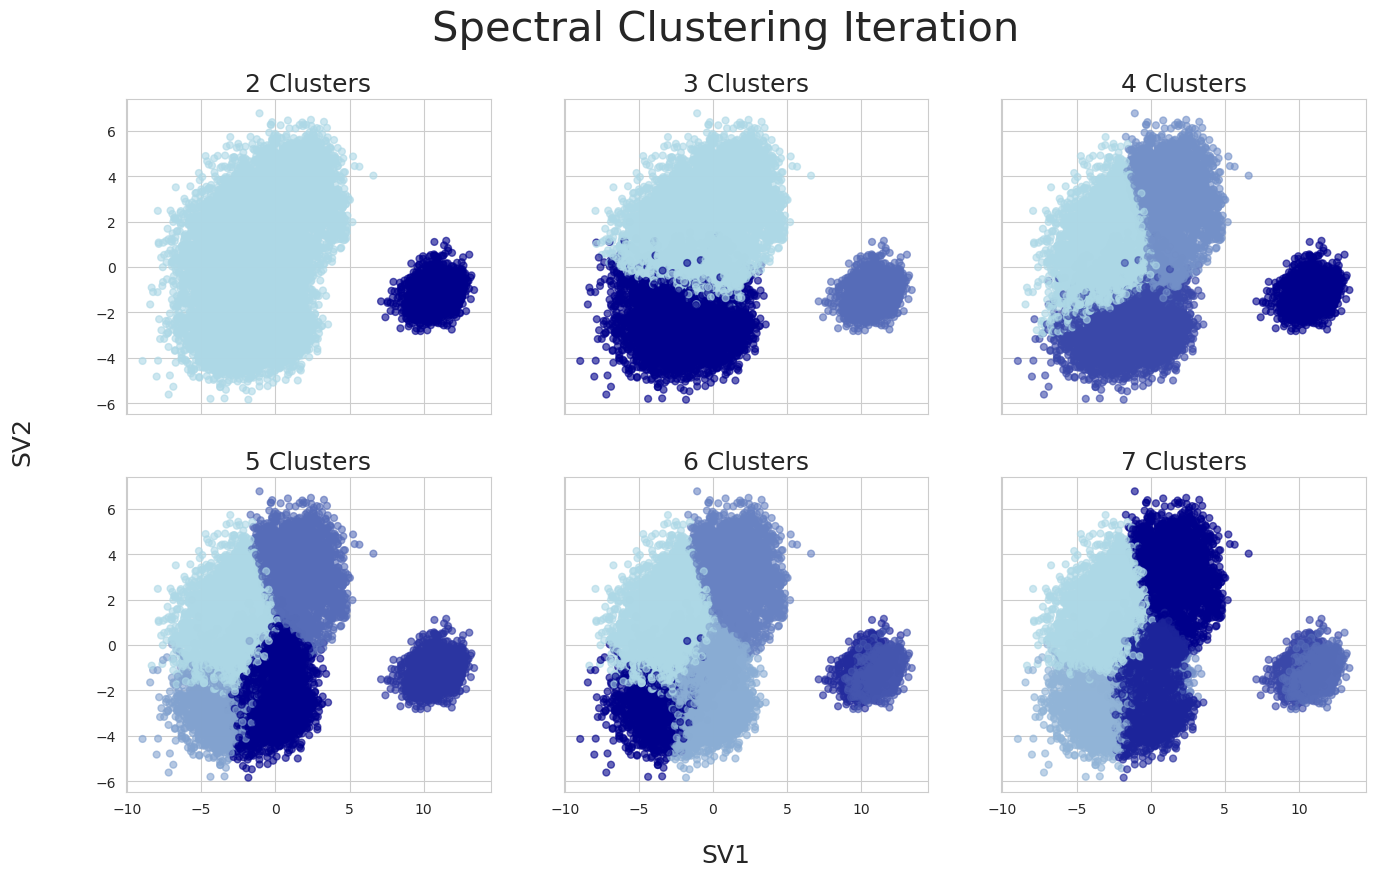

In [18]:
cost2 = range(2, 8)
fig, ax = plt.subplots(2, len(cost)//2, dpi=100, sharex=True, sharey=True, 
                           figsize=(16,9))

fig.suptitle("Spectral Clustering Iteration", fontsize=30)
fig.text(0.5, 0.04, 'SV1', ha='center', 
         va='center', fontsize=18)
fig.text(0.06, 0.5, 'SV2', ha='center', va='center', 
         rotation='vertical', fontsize=18)

df_val_sc = pd.DataFrame(index=['silhouette', 'calinski_harabaz', 
                             'davies_bouldin'])
for index, t in enumerate(cost2):
    y_predict_soccer2 = SC(n_clusters=t,
                            assign_labels='discretize',
                            n_neighbors=100,
                           n_components=t,
                            affinity='rbf',
                           random_state=143,
                            n_jobs=-1).fit_predict(X_new_svd)
    df_val_sc[t] = internalValidation(X_new_svd, y_predict_soccer2)
    if index < (len(cost2)//2):
        ax[0][index].scatter(X_new_svd[:,0], X_new_svd[:,1],
                             c=y_predict_soccer2, s=24, alpha=0.6,
                             cmap=cmap)
        ax[0][index].set_title(f'{t} Clusters', size=18)
    else:
        ax[1][index-len(cost2)//2].scatter(X_new_svd[:,0], X_new_svd[:,1],
                                          c=y_predict_soccer2, s=24,
                                          alpha=0.6, cmap=cmap)
        ax[1][index-len(cost)//2].set_title(f'{t} Clusters', size=18)

<span style="font-size: 12px">
    <center><b>Figure 11. Spectral Clustering Iterations</b></center>
</span><br>

Evaluating the spectral clustering results, the best cluster is two due to having overlaps, being parsimonious and the clusters are well separated. Three and four clusters can also be considered since the balance of data points per cluster is being traded off with the complexity of the model. 

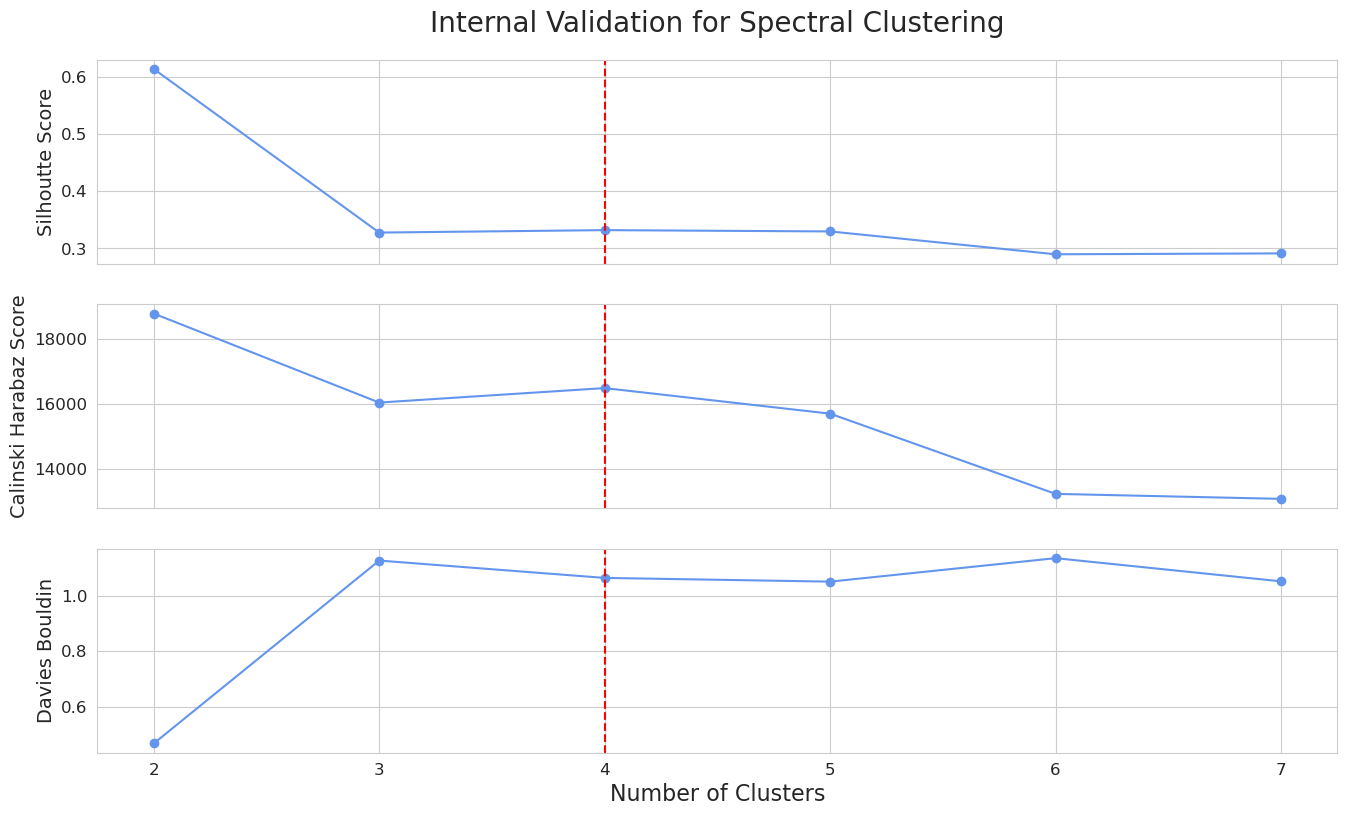

In [19]:
fig, ax = plt.subplots(3, 1, dpi=100, sharex=True, figsize=(16,9))

df_val_splot = df_val_sc.T

ax[0].set_title("Internal Validation for Spectral Clustering", 
                fontsize = 20,pad=20);

ax[0].plot(df_val_splot[[df_val_splot.columns[0]]], 'o-', c='cornflowerblue')
ax[0].set_ylabel('Silhoutte Score', fontsize = 14)
ax[0].axvline(x=4, color='r', linestyle='--')
ax[0].tick_params(axis='both', which='major', labelsize=12)

ax[1].plot(df_val_splot[[df_val_splot.columns[1]]], 'o-', c='cornflowerblue')
ax[1].set_ylabel('Calinski Harabaz Score', fontsize = 14)
ax[1].axvline(x=4, color='r', linestyle='--')
ax[1].tick_params(axis='both', which='major', labelsize=12)

ax[2].plot(df_val_splot[[df_val_splot.columns[2]]], 'o-', c='cornflowerblue')
ax[2].set_ylabel('Davies Bouldin', fontsize = 14)
ax[2].axvline(x=4, color='r', linestyle='--')
ax[2].tick_params(axis='both', which='major', labelsize=12)

plt.xlabel('Number of Clusters', fontsize = 16)
plt.show()

<span style="font-size: 12px">
    <center><b>Figure 12. Internal Validation Metrics of the Spectral Clustering Iterations</b></center>
</span><br>

The results of Spectral Clustering is almost the same as the GMM wherein the optimal cluster considering the visual evalution (since the clusters are highly separated) and the optimal results in the evaluation metrics is two clusters. But using the same argument in the GMM where two is not the ideal for the study, the next best model is selected. **For Spectral clustering, the chosen optimal number of clusters is four** which is more balanced between the number of points per cluster when compared to both two and three clusters.

<a id='SC'></a>
<h3 style="color:#324268; background-color: #ffffff; border: 1px solid #ffffff; padding: 10px 0;">Optimal Cluster</h3>

The optimal cluster is detemined by comparing the identified best cluster of the Gaussian Mixture Model and the Spectral Clustering. The same internal validation metircs are used to check which is the optimal cluster that will be used for the dataset. The visual representation of the clusters were also included on determining the optimal cluster.

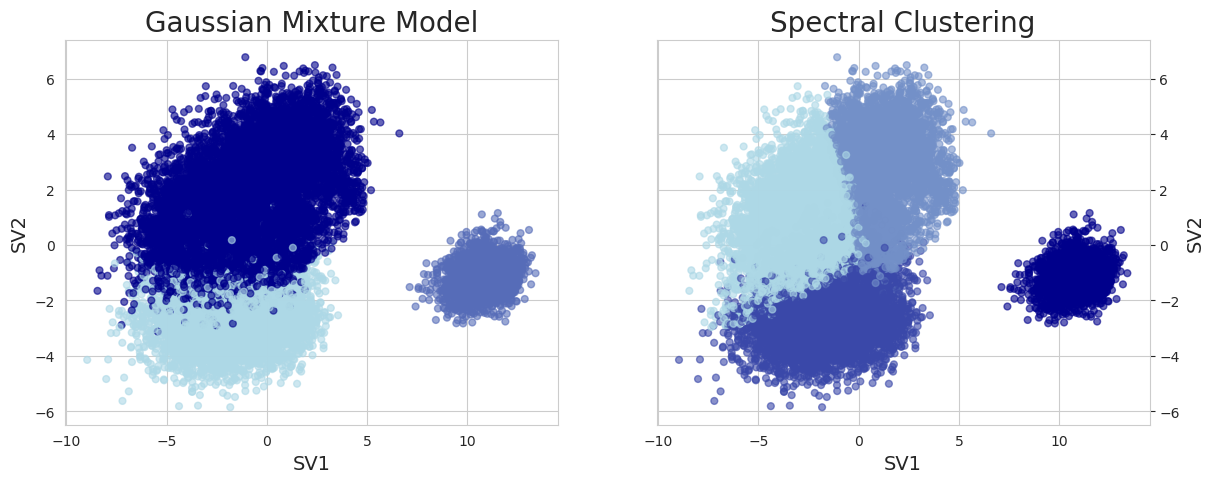

In [20]:
df_opt = pd.DataFrame(index=['silhouette', 'calinski_harabaz', 
                             'davies_bouldin'])

y_predict_soccer = GMM(n_components=3,
                        init_params='k-means++',
                        covariance_type='full',
                        tol=1e-2,
                        max_iter=100,
                        random_state=143,
                            n_init=1).fit_predict(X_new_svd)

df_opt['GMM'] = internalValidation(X_new_svd, y_predict_soccer) 

y_predict_soccer2 = SC(n_clusters=4,
                        assign_labels='discretize',
                        n_neighbors=100,
                       n_components=4,
                        affinity='rbf',
                       random_state=143,
                        n_jobs=-1).fit_predict(X_new_svd)

df_opt['SC'] = internalValidation(X_new_svd, y_predict_soccer2) 

fig, ax = plt.subplots(1, 2, dpi=100, figsize=(14,5))

ax[0].scatter(X_new_svd[:,0], X_new_svd[:,1],
                     c=y_predict_soccer, s=24, alpha=0.6,
                     cmap=cmap)
ax[0].set_xlabel('SV1', fontsize = 14)
ax[0].set_ylabel('SV2', fontsize = 14)
ax[0].set_title("Gaussian Mixture Model", fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=10)

ax[1].scatter(X_new_svd[:,0], X_new_svd[:,1],
                     c=y_predict_soccer2, s=24, alpha=0.6,
                     cmap=cmap)
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()            
ax[1].set_xlabel('SV1', fontsize = 14)
ax[1].set_ylabel('SV2', fontsize = 14)
ax[1].set_title("Spectral Clustering", fontsize=20);
ax[1].tick_params(axis='both', which='major', labelsize=10)

plt.show()

<span style="font-size: 12px">
    <center><b>Figure 13. Visual Comparison of the Two Best Model per Clustering Method</b></center>
</span><br>

Visualizing the two models by projecting them to the two singular vectors of the dataset, it can be seen that the Spectral Clustering has more balance between the clusters. The Spectral Clustering also has less overlaps in the edge of the cluster. Although both models are parsimonious since the models have only three and four clusters, the Spectral Clustering result with four clusters is also more compact when compared to the GMM which makes it the optimal model based on visual characteristics.

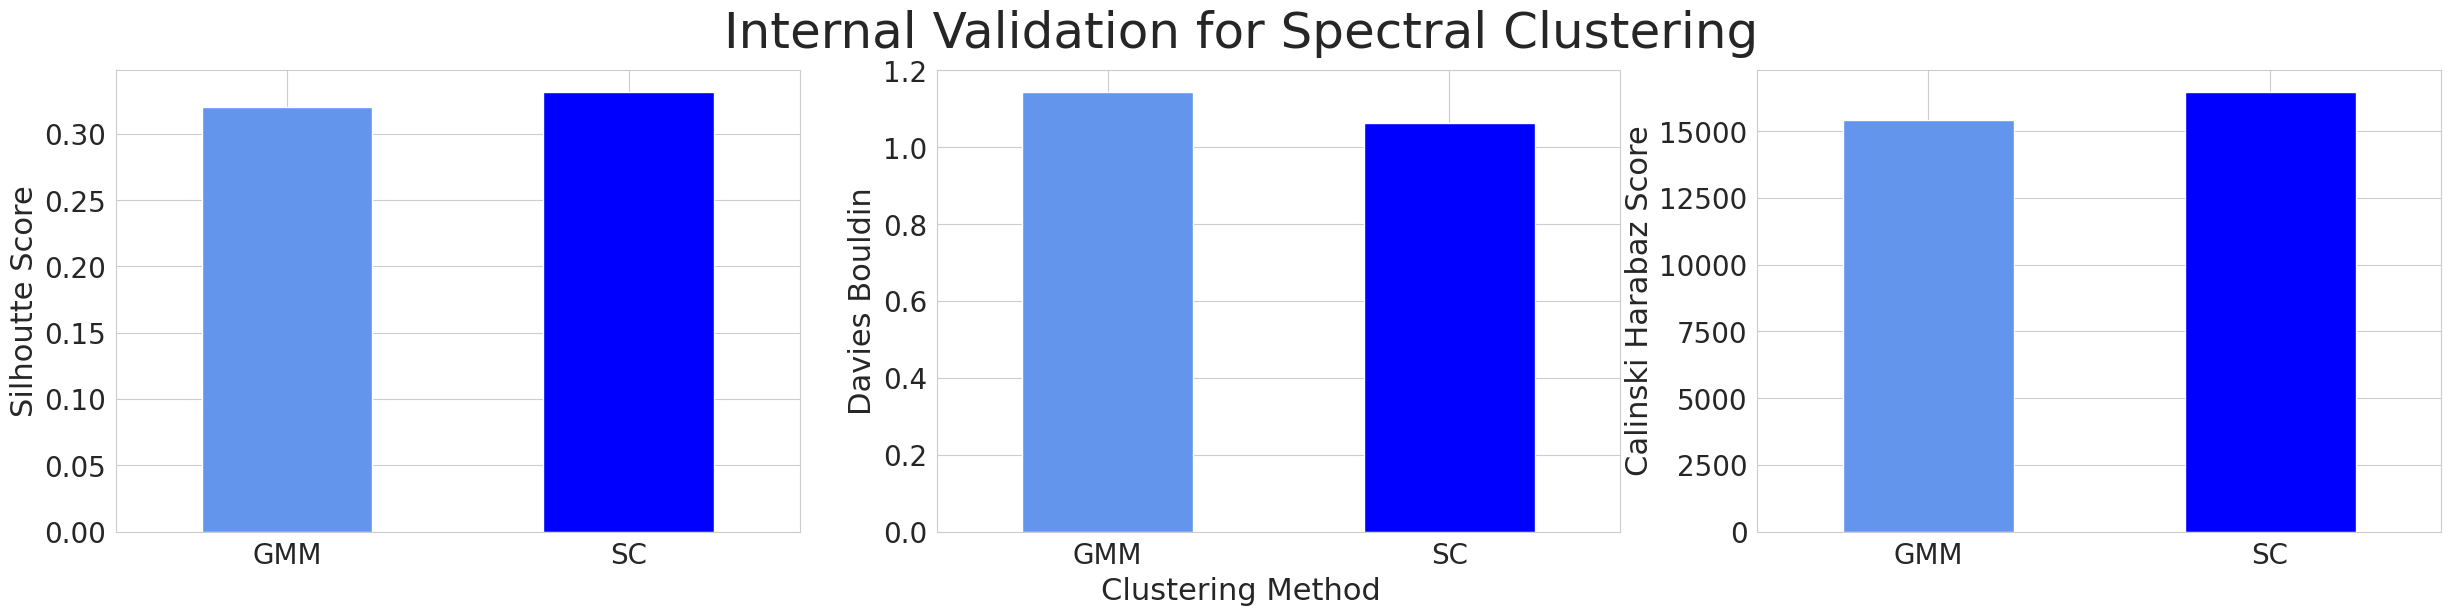

In [21]:
fig, ax = plt.subplots(1, 3, dpi=100, sharex=True, figsize=(30,6))

fig.suptitle("Internal Validation for Spectral Clustering", fontsize=36)

df_opt.iloc[0].plot(kind='bar', ax=ax[0], color=['cornflowerblue', 'blue'])
ax[0].set_ylabel('Silhoutte Score', fontsize = 22)
ax[0].set_xticklabels(labels=df_opt.columns, rotation=0)
ax[0].tick_params(axis='both', which='major', labelsize=20)

df_opt.iloc[2].plot(kind='bar', ax=ax[1], color=['cornflowerblue', 'blue'])
ax[1].set_ylabel('Davies Bouldin', fontsize = 22)
ax[1].set_xticklabels(labels=df_opt.columns, rotation=0)
ax[1].tick_params(axis='both', which='major', labelsize=20)

df_opt.iloc[1].plot(kind='bar', ax=ax[2], color=['cornflowerblue', 'blue'])
ax[2].set_ylabel('Calinski Harabaz Score', fontsize = 22)
ax[2].set_xticklabels(labels=df_opt.columns, rotation=0)
ax[2].tick_params(axis='both', which='major', labelsize=20)

fig.text(0.5, 0.01, 'Clustering Method', ha='center', 
         va='center', fontsize=22)


plt.show()

<span style="font-size: 12px">
    <center><b>Figure 14. Internal Validation Metrics of the Two Best Model per Clustering Method</b></center>
</span><br>

Comparing the models based on internal validation, the results are close but spectral clustering has the advantage on every evaluation metrics. **spectral clustering has a Silhoutte score closer to 1, a smaller Davies Boulding score, and higher Calinski-Harabaz score**. This validates the visual inspection above where spectral clustering has the more dense and compact clusters and the assignment of the data points to a cluster is well-matched.

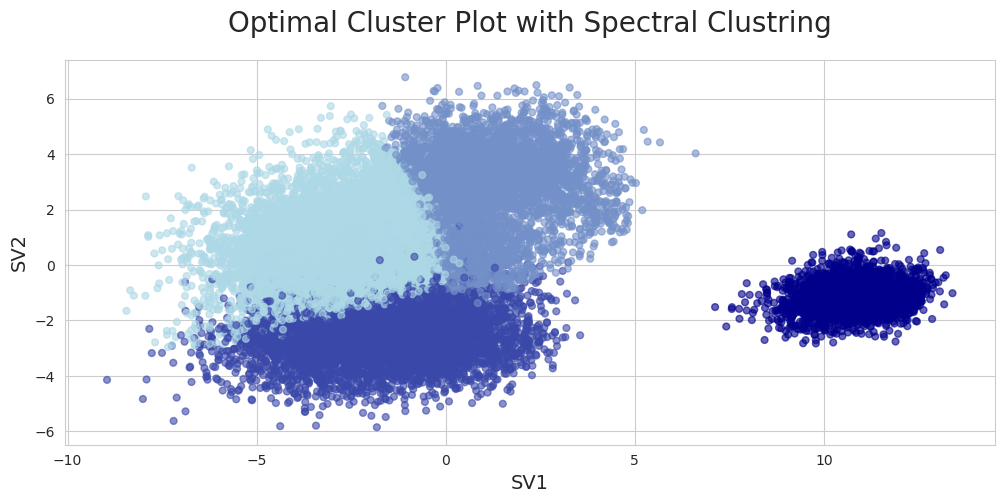

In [22]:
fig, ax = plt.subplots(figsize=(12, 5))
plt.scatter(X_new_svd[:,0], X_new_svd[:,1],
                             c=y_predict_soccer2, s=24, alpha=0.6,
                             cmap=cmap)

plt.xlabel('SV1', fontsize = 14)
plt.ylabel('SV2', fontsize = 14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.title("Optimal Cluster Plot with Spectral Clustring", fontsize = 20, pad=20);

<span style="font-size: 12px">
    <center><b>Figure 15. Scatter Plot of the Optimal Clustering Model</b></center>
</span><br>

In order to explain the resulting clusters using the optimal model, the values of the attributes are aggregated to show the average value of the ratings of the clusters. This will show the strengths and weaknesses of each cluster. However, since the singular vectors will not be as intuitive and explainable as the original features and the original features has a lot of dimensions to be considered. The ratings are grouped into major categories based on the skills in football which are offense, defense, ball control, physical, and goalkeepings.

In [23]:
X_soccer_unscaled['cluster'] = y_predict_soccer2

offense = ['attacking_crossing', 'attacking_finishing', 
           'attacking_heading_accuracy', 'attacking_volleys', 'skill_curve',
           'skill_fk_accuracy', 'power_shot_power', 'power_long_shots', 
            'mentality_penalties']
ball_control = ['skill_dribbling', 'skill_ball_control', 
                'mentality_positioning']
passing = ['attacking_short_passing', 'skill_long_passing']
defense = ['mentality_aggression', 'mentality_interceptions', 
           'defending_marking', 'defending_standing_tackle', 
           'defending_sliding_tackle']
physical = ['movement_acceleration', 'movement_sprint_speed', 
            'movement_agility', 'movement_reactions', 'movement_balance',
            'power_jumping', 'power_stamina', 'power_strength', 
            'mentality_vision', 'mentality_composure']
goalkeeping = ['goalkeeping_diving', 'goalkeeping_handling', 
               'goalkeeping_kicking', 'goalkeeping_positioning',
               'goalkeeping_reflexes']

In [24]:
df_stats = pd.DataFrame()
df_stats['Shooting'] = (X_soccer_unscaled.groupby('cluster')
                                         .mean()[offense].mean(axis=1))
df_stats['Ball_control'] = (X_soccer_unscaled.groupby('cluster')
                                        .mean()[ball_control].mean(axis=1))
df_stats['Passing'] = (X_soccer_unscaled.groupby('cluster')
                                        .mean()[passing].mean(axis=1))
df_stats['Defense'] = (X_soccer_unscaled.groupby('cluster')
                                        .mean()[defense].mean(axis=1))
df_stats['Physical'] = (X_soccer_unscaled.groupby('cluster')
                                         .mean()[physical].mean(axis=1))
df_stats['Goalkeeping'] = (X_soccer_unscaled.groupby('cluster')
                                            .mean()[goalkeeping].mean(axis=1))

In [25]:
player_attrib = X_soccer_unscaled.groupby('cluster')[['age', 'height_cm', 
                                                     'weight_kg', 
                                                     'preferred_foot']].mean()
df_statsall = player_attrib.join(df_stats)
df_statsall['Number of Players'] = (X_soccer_unscaled
                                    .groupby('cluster')['age'].count())
df_statsall

age   height_cm  weight_kg  preferred_foot   Shooting  \
cluster                                                                
0        26.521896  179.384287  73.742332        0.709693  55.945146   
1        24.289859  184.523680  77.648153        0.759732  38.348293   
2        24.375654  178.892179  73.015052        0.777651  57.134290   
3        26.266699  188.437623  81.960216        0.891945  17.652860   

         Ball_control    Passing    Defense   Physical  Goalkeeping  \
cluster                                                               
0           64.100049  66.658357  64.463474  67.765606    10.618074   
1           45.067774  52.306596  61.984032  58.492189    10.345152   
2           65.026342  56.927029  34.005563  65.273184    10.426342   
3           14.722986  26.446955  16.991945  44.568418    64.033301   

         Number of Players  
cluster                     
0                     6097  
1                     4033  
2                     6112  
3                     2036

<span style="font-size: 12px">
    <center><b>Table 6. Mean Player Ratings of Each Cluster</b></center>
</span><br>

The attributes of the clusters have distinct strengths and weakness based on the aggregated stats. Cluster 0 have notably high values in every football skills except goalkeeping while cluster 1 has relatively low shooting, ball control, and physical while having high defense. Cluster 2 are players with the highest shooting and ball control, high physical but low defense. Rounding up the clusters is Cluster 3 with the highest goalkeeping skills but the other attributes are very low. 

The non-skill features have different insights per cluster:
- Cluster 1 and 3 are the older players however the difference is only 2 years when compared to the other clusters
- Cluster 3 are the tallest players followed by Cluster 1 and Cluster 0 and 2 have low height values. The same trend is exhibited in weight
- Cluster 0 has the highest percentage of left-handed players, Cluster 1 and 2 have average amounts, and Cluster 3 are mostly right-handed players.

In order to gain more insights and check whether the values of the ratings are not influenced by outliers, outlier analysis is performed on each defined cluster. 

<a id='Outlier'></a>
<h2 style="color:#324268; background-color: #ffffff; border: 1px solid #ffffff; padding: 10px 0;">Outlier Analysis</h2>

Outlier analysis is a method used to identify and investigate data points that deviate significantly from the normal pattern of a dataset. It involves detecting these outliers, which are observations that exhibit unusual characteristics or lie outside the expected range. Various factors, such as measurement errors, unexpected events, data processing errors, etc., can cause these outliers. By analyzing outliers, one can gain insights into potential errors, anomalies, or rare events in the data. The goal is to understand the nature and impact of these outliers on the overall dataset and subsequent analyses. Outlier analysis helps ensure data quality, uncover valuable information, and make informed decisions regarding outlier treatment. <span style="font-size: 10px">[8]</span>

In this report, two outlier anaylis methods were performed on each cluster that were defined in the previous section:

`Local Outlier Factor` (LOF) is a density-based anomaly detection method that measures the local deviation of density of a given sample with respect to its neighbors. It starts by computing the reachability distance between each point and its k-nearest neighbors. LOF calculates the local reachability density, an inverse measure of the average reachability distances of a point's k-nearest neighbors. The LOF of each point is computed as the average of the ratio of the local reachability densities between the point and its k-nearest neighbors. Points with significantly lower density than their neighbors, reflected by a high LOF value, are considered outliers. LOF excels in identifying outliers in datasets with varying densities, as it considers the local density deviation around a data point. It is adept at detecting local outliers, which are anomalous within their local neighborhood, rather than the entire dataset. Additionally, LOF does not require a priori knowledge about the percentage of outliers in the dataset. <span style="font-size: 10px">[9]</span>

`Isolation Forest` is a machine learning algorithm for anomaly detection that works on the principle of isolating outliers instead of the conventional identification of normal instances. It constructs multiple decision trees, known as isolation trees or iTrees, by recursively selecting a random feature and splitting the data at a random value. The intuition is that anomalies are easier to isolate and require fewer random splits, resulting in shorter paths in the iTrees. The anomaly score is computed based on the average path length to isolate each instance, with shorter paths suggesting potential outliers. The algorithm classifies an instance as an outlier if its anomaly score exceeds a specified threshold. The Isolation Forest algorithm stands out for its efficiency in handling large, high-dimensional datasets without requiring dimension reduction or assuming any specific data distribution. Its random partitioning approach reduces the influence of irrelevant attributes, and it offers a degree of interpretability through the attributes and splits in the trees that lead to isolation. <span style="font-size: 10px">[10]</span>

In order to identify the best method for detecting the outliers, the same metrics as in the clustering section are used. These are the `Silhoutte score`, `Calinski-Harabaz score` (CH), and `Davies-Boulding score` (DB). These metrics will measure how the clustering is improved by the outlier analysis. To have comparable results and greater impact, both outlier analysis methods were set to detect 20% of the players in each cluster as outliers.

<a id='C0'></a>
<h3 style="color:#324268; background-color: #ffffff; border: 1px solid #ffffff; padding: 10px 0;">Cluster 0</h3>

In [26]:
df_cluster0 = X_soccer_unscaled.loc[X_soccer_unscaled['cluster'] == 0]
svd = TruncatedSVD(n_components=n_component, random_state=1337)
x0 = svd.fit_transform(df_cluster0)

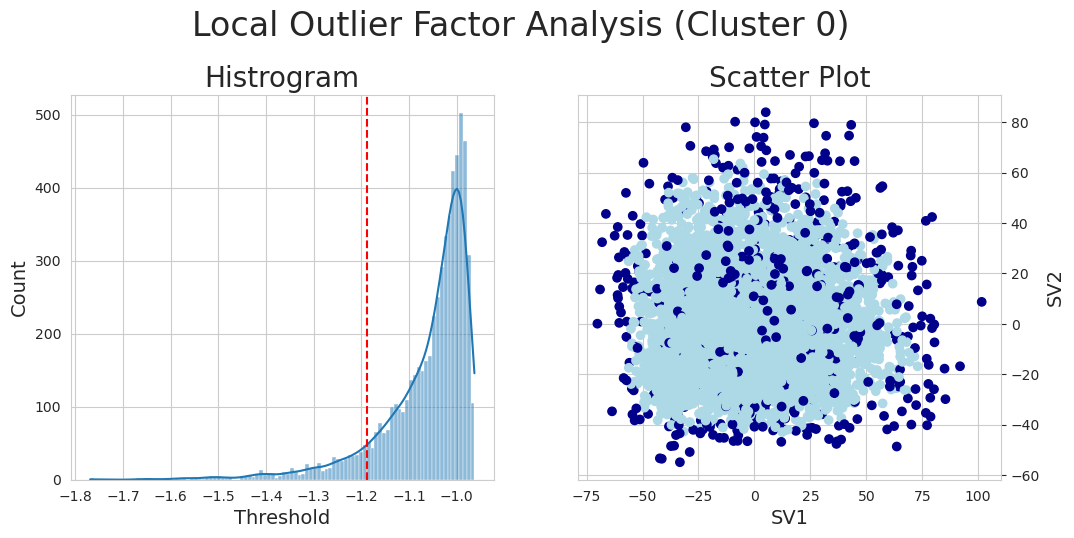

In [27]:
k = 100
model = LocalOutlierFactor(n_neighbors=k, contamination=0.1) 

# prediction of outliers is based on contamination level
y_pred_lof0 = model.fit_predict(x0)
LOF_scores0 = model.negative_outlier_factor_

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Local Outlier Factor Analysis (Cluster 0)", fontsize=24, y=1.05)

sns.histplot(LOF_scores0, bins=100, ax=ax[0], kde=True)
ax[0].set_xlabel('Threshold', fontsize = 14)
ax[0].set_ylabel('Count', fontsize = 14)
ax[0].set_title("Histrogram", fontsize=20)
ax[0].axvline(x=np.percentile(LOF_scores0, q=10), color='r', linestyle='--');
ax[0].tick_params(axis='both', which='major', labelsize=10)

# prediction of outliers is based on contamination level
y_pred_lof0 = (LOF_scores0 < np.percentile(LOF_scores0, q=10))

# fig, ax = plt.subplots(figsize=(12, 5))
ax[1].scatter(x0[:, 1], x0[:, 2], c=y_pred_lof0, cmap=cmap)
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()            
ax[1].set_xlabel('SV1', fontsize = 14)
ax[1].set_ylabel('SV2', fontsize = 14)
ax[1].set_title("Scatter Plot", fontsize=20);
ax[1].tick_params(axis='both', which='major', labelsize=10)
plt.show()

<span style="font-size: 12px">
    <center><b>Figure 16. Histogram and Scatter Plot of the Local Outlier Factor Analysis for Cluster 0</b></center>
</span><br>

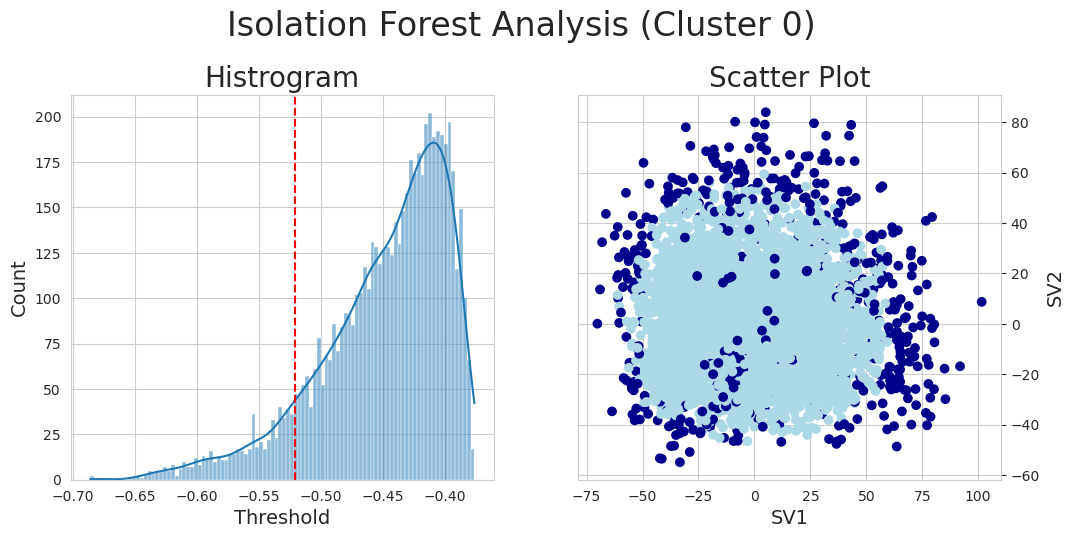

In [28]:
model = IsolationForest(n_estimators=100, contamination=0.1, 
                        random_state=143)
model.fit(x0)

# prediction of outliers is based on contamination level
y_pred_if0 = model.fit_predict(x0)
IF_scores0 = model.score_samples(x0)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Isolation Forest Analysis (Cluster 0)", fontsize=24, y=1.05)

sns.histplot(IF_scores0, bins=100, ax=ax[0], kde=True)
ax[0].set_xlabel('Threshold', fontsize = 14)
ax[0].set_ylabel('Count', fontsize = 14)
ax[0].set_title("Histrogram", fontsize=20);
ax[0].axvline(x=np.percentile(IF_scores0, q=10), color='r', linestyle='--');
ax[0].tick_params(axis='both', which='major', labelsize=10)

# prediction of outliers is based on contamination level
y_pred_if0 = (IF_scores0 < np.percentile(IF_scores0, q=10))

ax[1].scatter(x0[:, 1], x0[:, 2], c=y_pred_if0, cmap=cmap)
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()            
ax[1].set_xlabel('SV1', fontsize = 14)
ax[1].set_ylabel('SV2', fontsize = 14)
ax[1].set_title("Scatter Plot", fontsize=20);
ax[1].tick_params(axis='both', which='major', labelsize=10)
plt.show()

<span style="font-size: 12px">
    <center><b>Figure 17. Histogram and Scatter Plot of the Isolation Forest Analysis for Cluster 0</b></center>
</span><br>

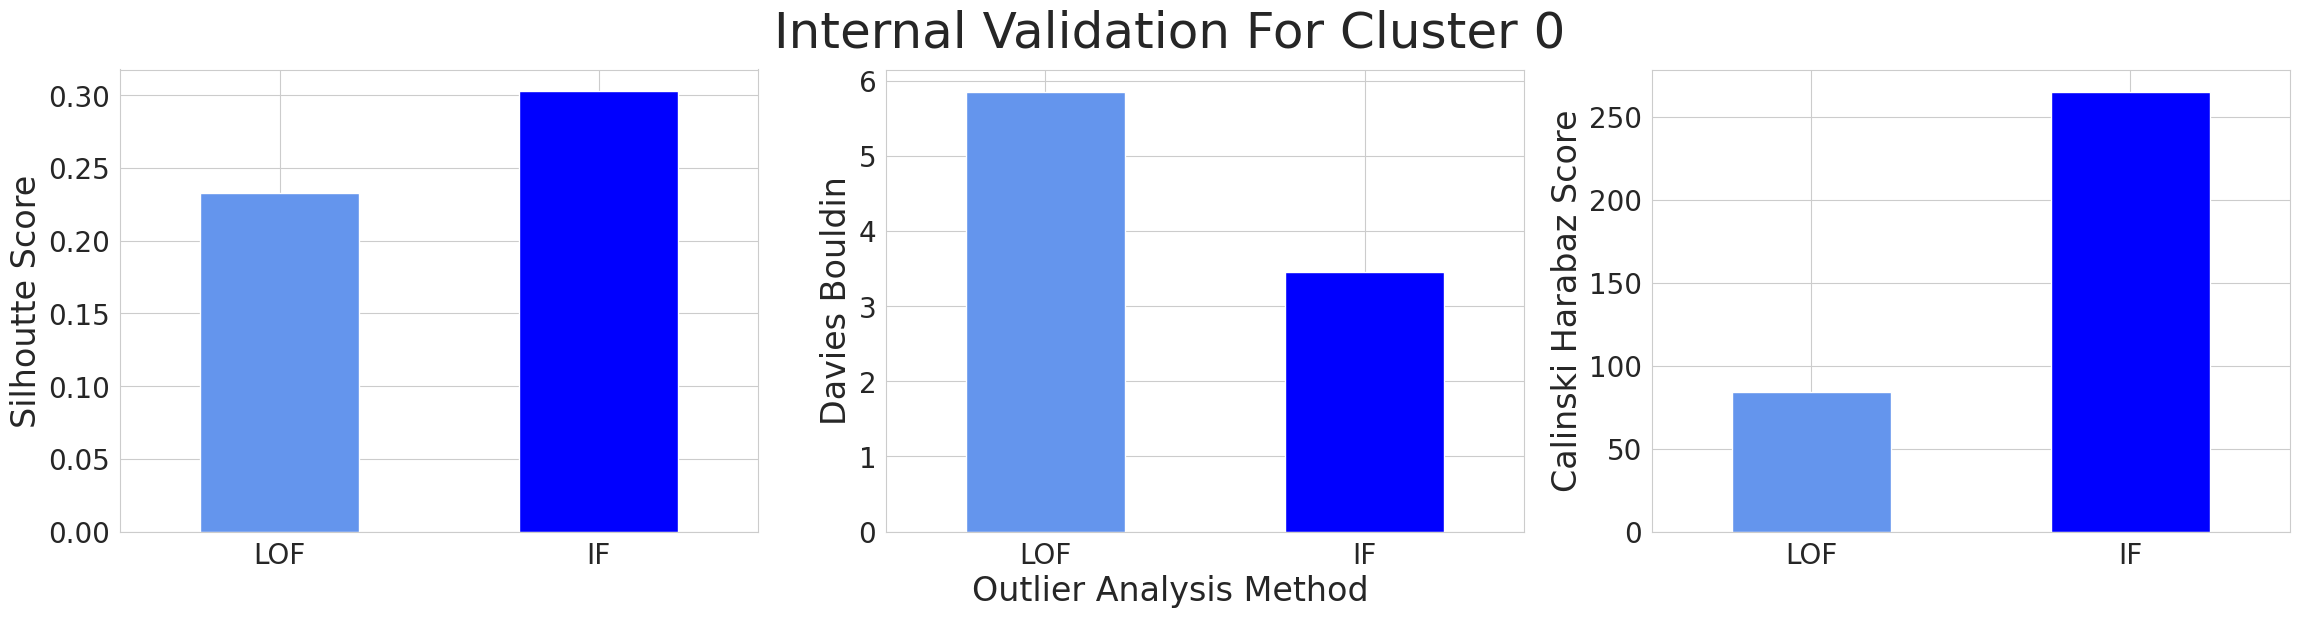

In [29]:
# Internal evaluation of the two methods
df_c0 = pd.DataFrame(index=['silhouette', 'calinski_harabaz', 
                             'davies_bouldin'])
df_c0['lof'] = internalValidation(x0, y_pred_lof0) 
df_c0['if'] = internalValidation(x0, y_pred_if0)

# Plotting the internal evaluation for comparison
fig, ax = plt.subplots(1, 3, dpi=100, sharex=True, figsize=(28, 6))
outlier_col = ['LOF', 'IF']
fig.suptitle("Internal Validation For Cluster 0", fontsize=36)

df_c0.iloc[0].plot(kind='bar', ax=ax[0], color=['cornflowerblue', 'blue'])
ax[0].set_ylabel('Silhoutte Score', fontsize = 24)
ax[0].set_xticklabels(labels=outlier_col, rotation=0)
ax[0].tick_params(axis='both', which='major', labelsize=20)

df_c0.iloc[2].plot(kind='bar', ax=ax[1], color=['cornflowerblue', 'blue'])
ax[1].set_ylabel('Davies Bouldin', fontsize = 24)
ax[1].set_xticklabels(labels=outlier_col, rotation=0)
ax[1].tick_params(axis='both', which='major', labelsize=20)

df_c0.iloc[1].plot(kind='bar', ax=ax[2], color=['cornflowerblue', 'blue'])
ax[2].set_ylabel('Calinski Harabaz Score', fontsize = 24)
ax[2].set_xticklabels(labels=outlier_col, rotation=0)
ax[2].tick_params(axis='both', which='major', labelsize=20)

fig.text(0.5, 0.01, 'Outlier Analysis Method', ha='center', 
         va='center', fontsize=24)
plt.show()

<span style="font-size: 12px">
    <center><b>Figure 18. Internal Validation Evaluation of the Outlier Analysis for Cluster 0</b></center>
</span><br>

For cluster 0, the visual representation projects that there are more outliers identified in the LOF compared to the Isolation Forest (IF). The results of the internal validation metrics are also aligning with the results of the scatter plot. All three metrics indicates that IF is the better outlier analysis method compared to LOF. Note that cluster 0 is a subset of the whole dataset which is why the values for the DB score and CH score are of different magnitudes.

<a id='C1'></a>
<h3 style="color:#324268; background-color: #ffffff; border: 1px solid #ffffff; padding: 10px 0;">Cluster 1</h3>

In [30]:
df_cluster1 = X_soccer_unscaled.loc[X_soccer_unscaled['cluster'] == 1]
svd = TruncatedSVD(n_components=n_component, random_state=1337)
x1 = svd.fit_transform(df_cluster1)

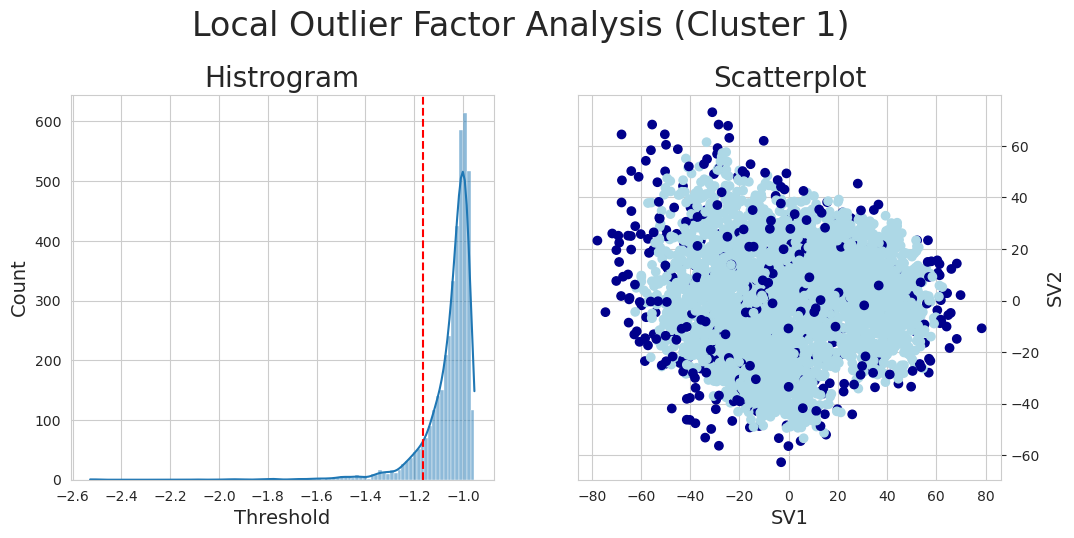

In [31]:
k = 100
model = LocalOutlierFactor(n_neighbors=k, contamination=0.1)

# prediction of outliers is based on contamination level
y_pred_lof1 = model.fit_predict(x1)
LOF_scores1 = model.negative_outlier_factor_

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Local Outlier Factor Analysis (Cluster 1)", fontsize=24, y=1.05)

sns.histplot(LOF_scores1, bins=100, ax=ax[0], kde=True)
ax[0].set_xlabel('Threshold', fontsize=14)
ax[0].set_ylabel('Count', fontsize=14)
ax[0].set_title("Histrogram", fontsize=20);
ax[0].axvline(x=np.percentile(LOF_scores1, q=10), color='r', linestyle='--');
ax[0].tick_params(axis='both', which='major', labelsize=10)

# prediction of outliers is based on contamination level
y_pred_lof1 = (LOF_scores1 < np.percentile(LOF_scores1, q=10))

# fig, ax = plt.subplots(figsize=(12, 5))
ax[1].scatter(x1[:, 1], x1[:, 2], c=y_pred_lof1, cmap=cmap)
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()            
ax[1].set_xlabel('SV1', fontsize = 14)
ax[1].set_ylabel('SV2', fontsize = 14)
ax[1].set_title("Scatterplot", fontsize=20);
ax[1].tick_params(axis='both', which='major', labelsize=10)
plt.show()

<span style="font-size: 12px">
    <center><b>Figure 19. Histogram and Scatter Plot of the Local Outlier Factor Analysis for Cluster 1</b></center>
</span><br>

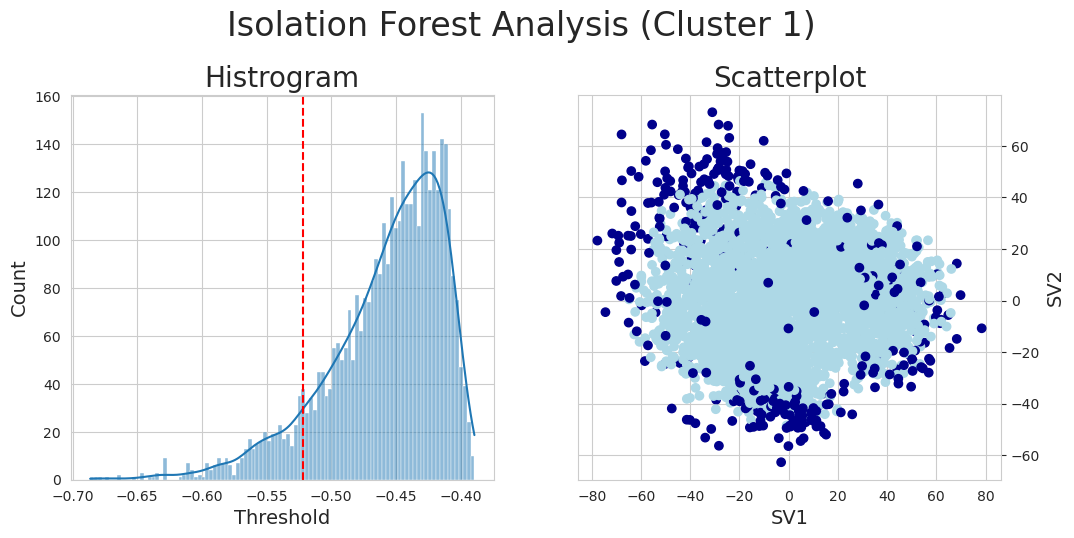

In [32]:
model = IsolationForest(n_estimators=100, contamination=0.1, 
                        random_state=143)
model.fit(x1)

# prediction of outliers is based on contamination level
y_pred_if1 = model.fit_predict(x1)
IF_scores1 = model.score_samples(x1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Isolation Forest Analysis (Cluster 1)", fontsize=24, y=1.05)

sns.histplot(IF_scores1, bins=100, ax=ax[0], kde=True)
ax[0].set_xlabel('Threshold', fontsize = 14)
ax[0].set_ylabel('Count', fontsize = 14)
ax[0].set_title("Histrogram", fontsize=20);
ax[0].axvline(x=np.percentile(IF_scores1, q=10), color='r', linestyle='--');
ax[0].tick_params(axis='both', which='major', labelsize=10)

# prediction of outliers is based on contamination level
y_pred_if1 = (IF_scores1 < np.percentile(IF_scores1, q=10))

ax[1].scatter(x1[:, 1], x1[:, 2], c=y_pred_if1, cmap=cmap)
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()            
ax[1].set_xlabel('SV1', fontsize = 14)
ax[1].set_ylabel('SV2', fontsize = 14)
ax[1].set_title("Scatterplot", fontsize=20);
ax[1].tick_params(axis='both', which='major', labelsize=10)
plt.show()

<span style="font-size: 12px">
    <center><b>Figure 20. Histogram and Scatter Plot of the Isolation Forest Analysis for Cluster 1</b></center>
</span><br>

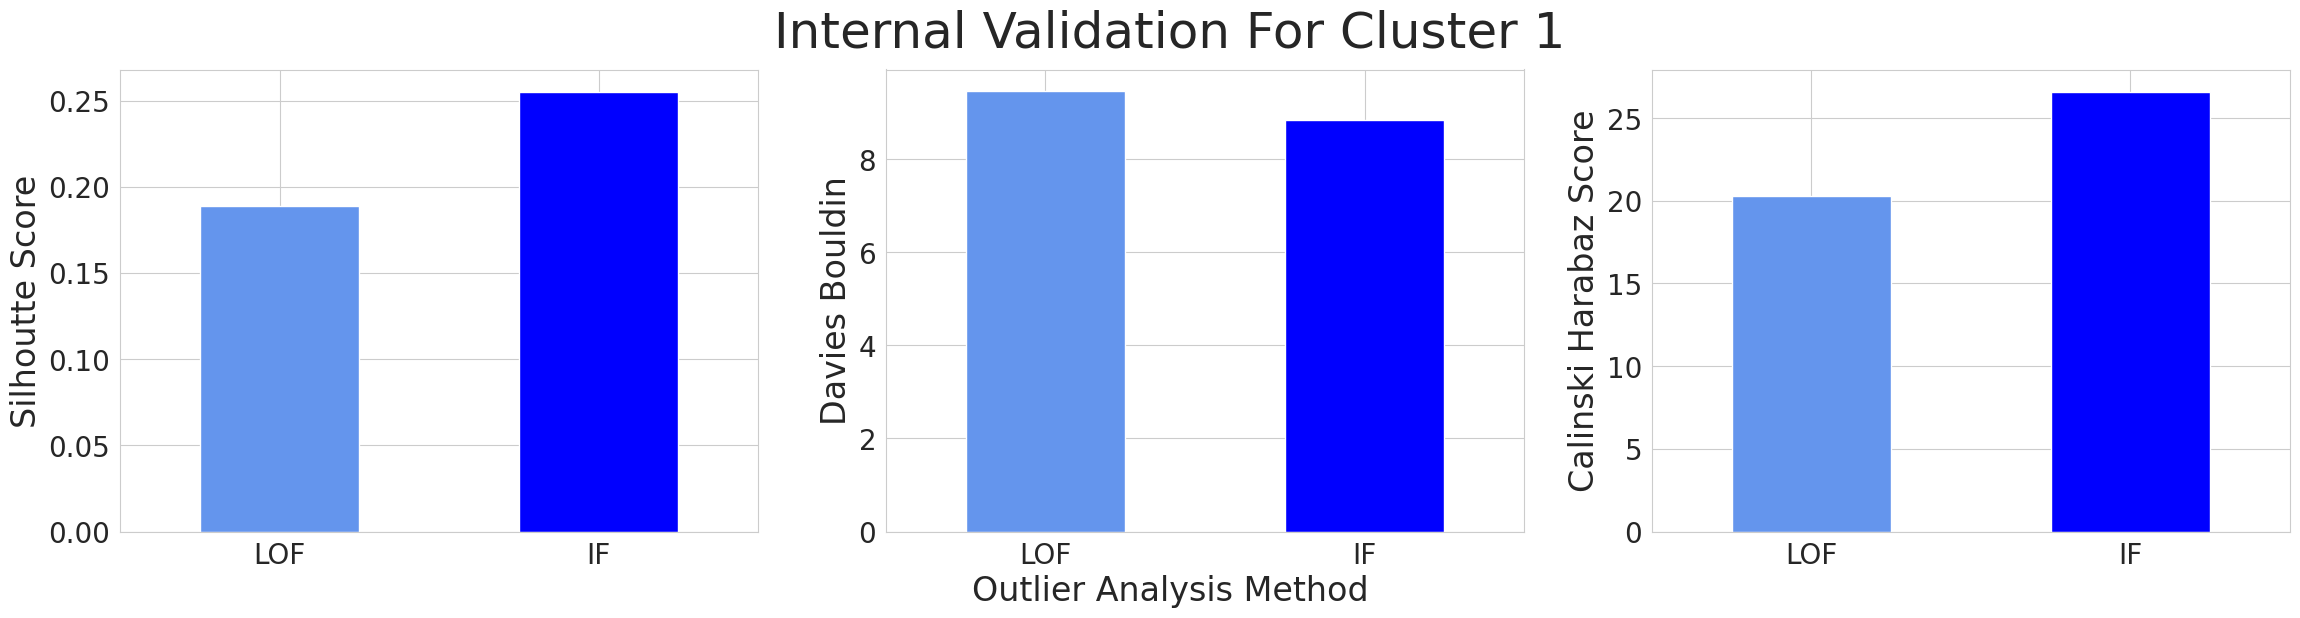

In [33]:
# Internal evaluation of the two methods
df_c1 = pd.DataFrame(index=['silhouette', 'calinski_harabaz', 
                             'davies_bouldin'])
df_c1['lof'] = internalValidation(x1, y_pred_lof1) 
df_c1['if'] = internalValidation(x1, y_pred_if1) 

# Plotting the internal evaluation for comparison
fig, ax = plt.subplots(1, 3, dpi=100, sharex=True, figsize=(28, 6))
outlier_col = ['LOF', 'IF']
fig.suptitle("Internal Validation For Cluster 1", fontsize=36)

df_c1.iloc[0].plot(kind='bar', ax=ax[0], color=['cornflowerblue', 'blue'])
ax[0].set_ylabel('Silhoutte Score', fontsize = 24)
ax[0].set_xticklabels(labels=outlier_col, rotation=0)
ax[0].tick_params(axis='both', which='major', labelsize=20)

df_c1.iloc[2].plot(kind='bar', ax=ax[1], color=['cornflowerblue', 'blue'])
ax[1].set_ylabel('Davies Bouldin', fontsize = 24)
ax[1].set_xticklabels(labels=outlier_col, rotation=0)
ax[1].tick_params(axis='both', which='major', labelsize=20)

df_c1.iloc[1].plot(kind='bar', ax=ax[2], color=['cornflowerblue', 'blue'])
ax[2].set_ylabel('Calinski Harabaz Score', fontsize = 24)
ax[2].set_xticklabels(labels=outlier_col, rotation=0)
ax[2].tick_params(axis='both', which='major', labelsize=20)

fig.text(0.5, 0.01, 'Outlier Analysis Method', ha='center', 
         va='center', fontsize=24)
plt.show()

<span style="font-size: 12px">
    <center><b>Figure 21. Internal Validation Evaluation of the Outlier Analysis for Cluster 1</b></center>
</span><br>

The results for Cluster 1 are similar for Cluster 0 in the internal validation metrics. However, the difference between the two methods are closer in Cluster 1 compared to Cluster 2. Another noticeable insight in the scatter plot is that in the IF, the results follow the shape of the plot wherein the outliers are concentrated in the upper left and lower right corners of the plot. This is another factor why IF is the optimal model for cluster 1 since LOF is more balanced on the edges of the plot.

<a id='C2'></a>
<h3 style="color:#324268; background-color: #ffffff; border: 1px solid #ffffff; padding: 10px 0;">Cluster 2</h3>

In [34]:
df_cluster2 = X_soccer_unscaled.loc[X_soccer_unscaled['cluster'] == 2]
svd = TruncatedSVD(n_components=n_component, random_state=1337)
x2 = svd.fit_transform(df_cluster2)

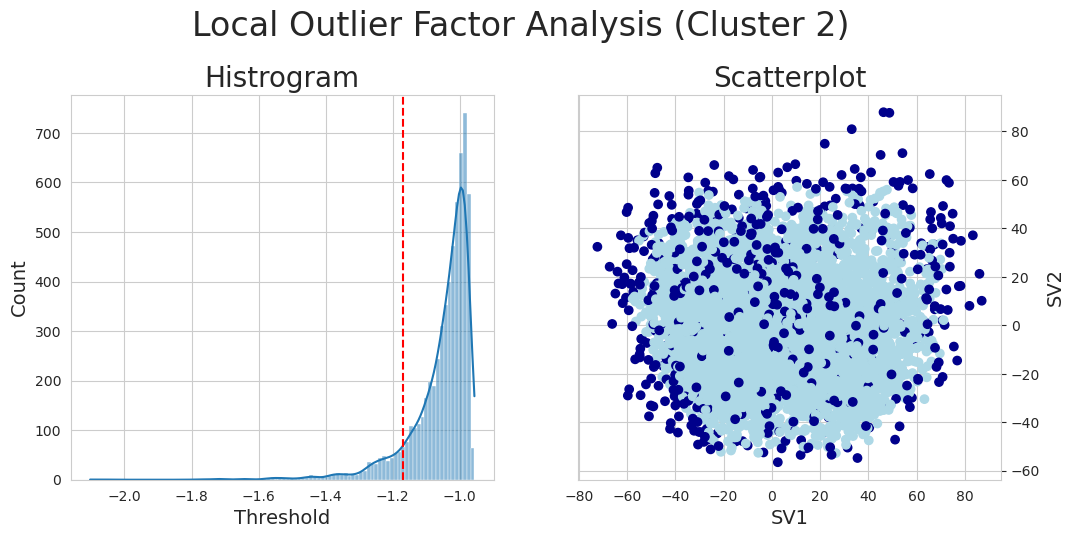

In [35]:
k = 100
model = LocalOutlierFactor(n_neighbors=k, contamination=0.1) 

# prediction of outliers is based on contamination level
y_pred_lof2 = model.fit_predict(x2)
LOF_scores2 = model.negative_outlier_factor_

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Local Outlier Factor Analysis (Cluster 2)", fontsize=24, y=1.05)

sns.histplot(LOF_scores2, bins=100, ax=ax[0], kde=True)
ax[0].set_xlabel('Threshold', fontsize = 14)
ax[0].set_ylabel('Count', fontsize = 14)
ax[0].set_title("Histrogram", fontsize=20);
ax[0].axvline(x=np.percentile(LOF_scores2, q=10), color='r', linestyle='--');
ax[0].tick_params(axis='both', which='major', labelsize=10)

# prediction of outliers is based on contamination level
y_pred_lof2 = (LOF_scores2 < np.percentile(LOF_scores2, q=10))

ax[1].scatter(x2[:, 1], x2[:, 2], c=y_pred_lof2, cmap=cmap)
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()            
ax[1].set_xlabel('SV1', fontsize = 14)
ax[1].set_ylabel('SV2', fontsize = 14)
ax[1].set_title("Scatterplot", fontsize=20);
ax[1].tick_params(axis='both', which='major', labelsize=10)
plt.show()

<span style="font-size: 12px">
    <center><b>Figure 22. Histogram and Scatter Plot of the Outlier Factor Analysis for Cluster 2</b></center>
</span><br>

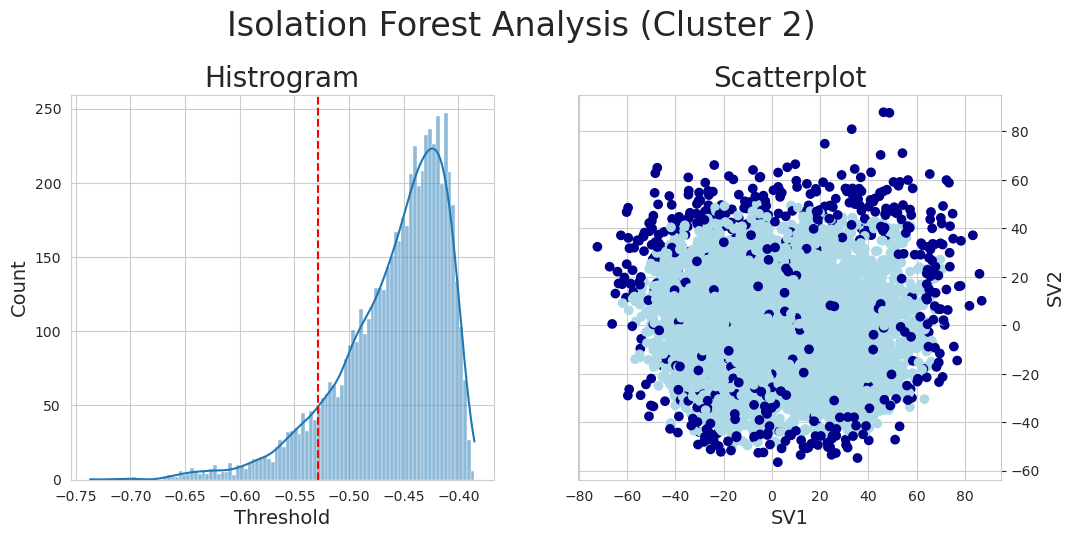

In [36]:
model = IsolationForest(n_estimators=100, contamination=0.1, 
                        random_state=143)
model.fit(x2)

# prediction of outliers is based on contamination level
y_pred_if2 = model.fit_predict(x2)
IF_scores2 = model.score_samples(x2)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Isolation Forest Analysis (Cluster 2)", fontsize=24, y=1.05)

sns.histplot(IF_scores2, bins=100, ax=ax[0], kde=True)
ax[0].set_xlabel('Threshold', fontsize = 14)
ax[0].set_ylabel('Count', fontsize = 14)
ax[0].set_title("Histrogram", fontsize=20);
ax[0].axvline(x=np.percentile(IF_scores2, q=10), color='r', linestyle='--');
ax[0].tick_params(axis='both', which='major', labelsize=10)

# prediction of outliers is based on contamination level
y_pred_if2 = (IF_scores2 < np.percentile(IF_scores2, q=10))

ax[1].scatter(x2[:, 1], x2[:, 2], c=y_pred_if2, cmap=cmap)
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()            
ax[1].set_xlabel('SV1', fontsize = 14)
ax[1].set_ylabel('SV2', fontsize = 14)
ax[1].set_title("Scatterplot", fontsize=20);
ax[1].tick_params(axis='both', which='major', labelsize=10)
plt.show()

<span style="font-size: 12px">
    <center><b>Figure 23. Histogram and Scatter Plot of the Isolation Forest Analysis for Cluster 2</b></center>
</span><br>

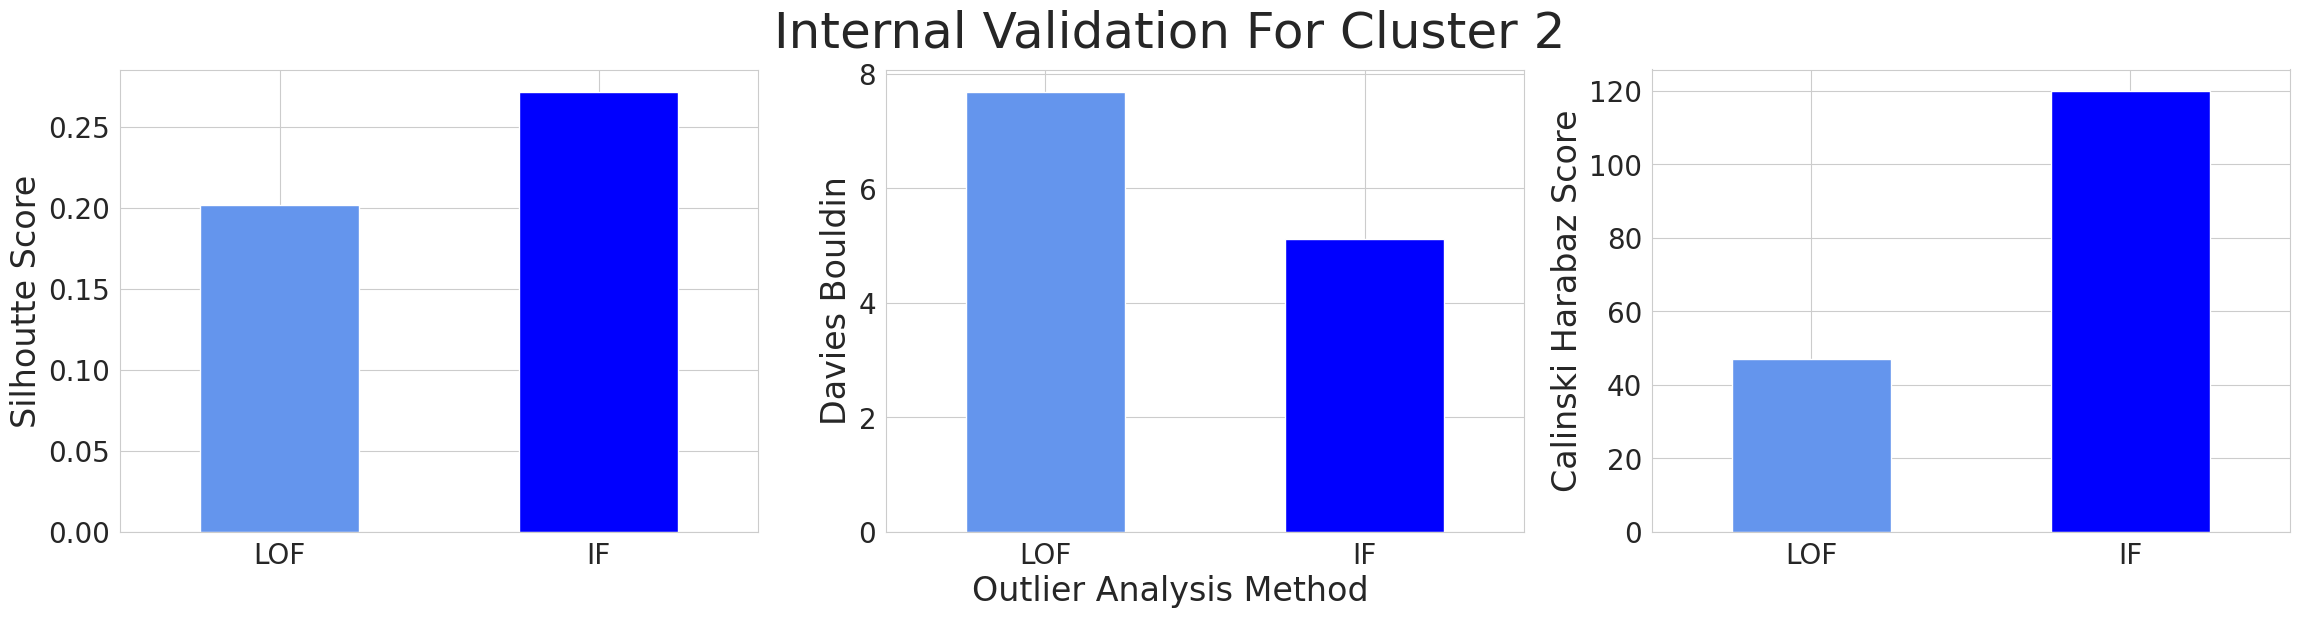

In [37]:
# Internal evaluation of the two methods
df_c2 = pd.DataFrame(index=['silhouette', 'calinski_harabaz', 
                             'davies_bouldin'])
df_c2['lof'] = internalValidation(x2, y_pred_lof2)
df_c2['if'] = internalValidation(x2, y_pred_if2) 

# Plotting the internal evaluation for comparison
fig, ax = plt.subplots(1, 3, dpi=100, sharex=True, figsize=(28, 6))
outlier_col = ['LOF', 'IF']
fig.suptitle("Internal Validation For Cluster 2", fontsize=36)

df_c2.iloc[0].plot(kind='bar', ax=ax[0], color=['cornflowerblue', 'blue'])
ax[0].set_ylabel('Silhoutte Score', fontsize = 24)
ax[0].set_xticklabels(labels=outlier_col, rotation=0)
ax[0].tick_params(axis='both', which='major', labelsize=20)

df_c2.iloc[2].plot(kind='bar', ax=ax[1], color=['cornflowerblue', 'blue'])
ax[1].set_ylabel('Davies Bouldin', fontsize = 24)
ax[1].set_xticklabels(labels=outlier_col, rotation=0)
ax[1].tick_params(axis='both', which='major', labelsize=20)

df_c2.iloc[1].plot(kind='bar', ax=ax[2], color=['cornflowerblue', 'blue'])
ax[2].set_ylabel('Calinski Harabaz Score', fontsize = 24)
ax[2].set_xticklabels(labels=outlier_col, rotation=0)
ax[2].tick_params(axis='both', which='major', labelsize=20)

fig.text(0.5, 0.01, 'Outlier Analysis Method', ha='center', 
         va='center', fontsize=24)
plt.show()

<span style="font-size: 12px">
    <center><b>Figure 24. Internal Validation Evaluation of the Outlier Analysis for Cluster 2</b></center>
</span><br>

The same trend of the first two clusters is exhibited in Cluster 2 wherein IF is the better model. The difference between the internal validation metrics are big which is similar to the results of Cluster 0. The scatter plot of the outlier analysis describes that the LOF does not detect the bottom data points as outlier and in turn identified the points at the middle as outliers. For IF, the edges of the plots are seen as the outliers with the bottom data points being also identified and replacing the middle points identified in the LOF.

<a id='C3'></a>
<h3 style="color:#324268; background-color: #ffffff; border: 1px solid #ffffff; padding: 10px 0;">Cluster 3</h3>

In [38]:
df_cluster3 = X_soccer_unscaled.loc[X_soccer_unscaled['cluster'] == 3]
svd = TruncatedSVD(n_components=n_component, random_state=1337)
x3 = svd.fit_transform(df_cluster3)

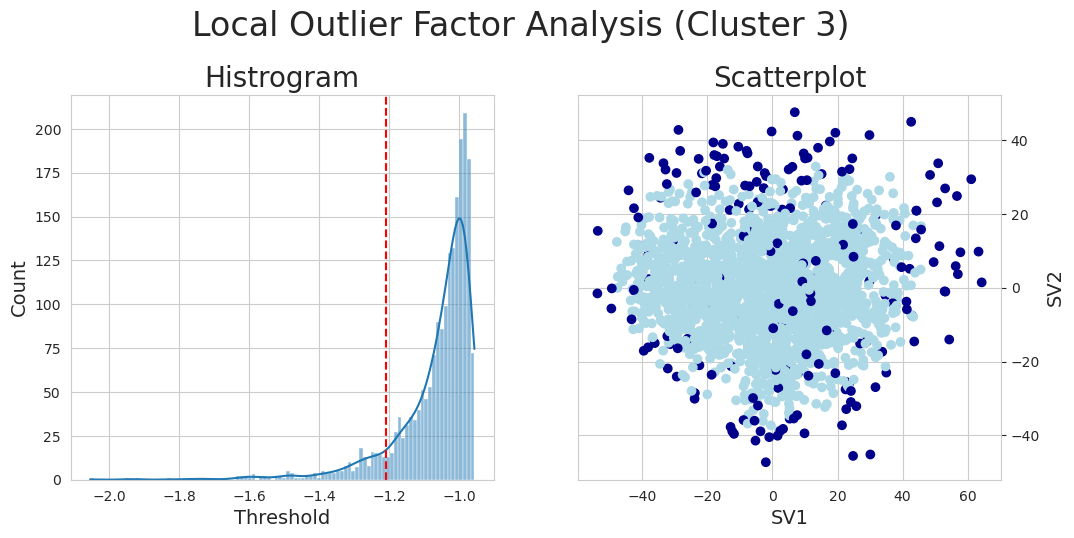

In [39]:
k = 100
model = LocalOutlierFactor(n_neighbors=k, contamination=0.1) 

# prediction of outliers is based on contamination level
y_pred_lof3 = model.fit_predict(x3)
LOF_scores3 = model.negative_outlier_factor_

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Local Outlier Factor Analysis (Cluster 3)", fontsize=24, y=1.05)

sns.histplot(LOF_scores3, bins=100, ax=ax[0], kde=True)
ax[0].set_xlabel('Threshold', fontsize = 14)
ax[0].set_ylabel('Count', fontsize = 14)
ax[0].set_title("Histrogram", fontsize=20);
ax[0].axvline(x=np.percentile(LOF_scores3, q=10), color='r', linestyle='--');
ax[0].tick_params(axis='both', which='major', labelsize=10)

# prediction of outliers is based on contamination level
y_pred_lof3 = (LOF_scores3 < np.percentile(LOF_scores3, q=10))

# fig, ax = plt.subplots(figsize=(12, 5))
ax[1].scatter(x3[:, 1], x3[:, 2], c=y_pred_lof3, cmap=cmap)
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()            
ax[1].set_xlabel('SV1', fontsize = 14)
ax[1].set_ylabel('SV2', fontsize = 14)
ax[1].set_title("Scatterplot", fontsize=20);
ax[1].tick_params(axis='both', which='major', labelsize=10)
plt.show()

<span style="font-size: 12px">
    <center><b>Figure 25. Histogram and Scatter Plot of the Local Outlier Factor Analysis for Cluster 3</b></center>
</span><br>

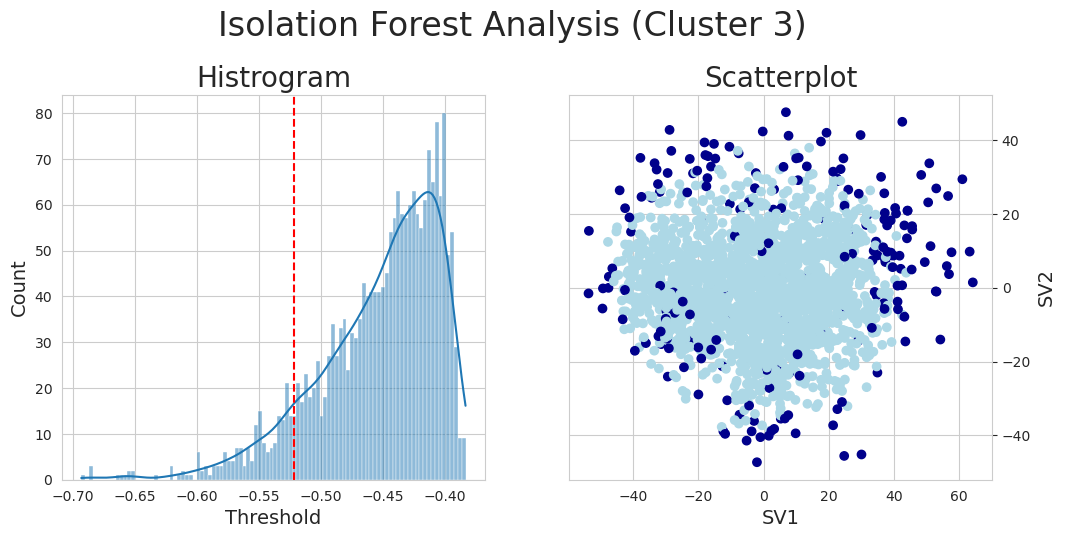

In [40]:
model = IsolationForest(n_estimators=100, contamination=0.1, 
                        random_state=143)
model.fit(x3)

# prediction of outliers is based on contamination level
y_pred_if3 = model.fit_predict(x3)
IF_scores3 = model.score_samples(x3)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Isolation Forest Analysis (Cluster 3)", fontsize=24, y=1.05)

sns.histplot(IF_scores3, bins=100, ax=ax[0], kde=True)
ax[0].set_xlabel('Threshold', fontsize = 14)
ax[0].set_ylabel('Count', fontsize = 14)
ax[0].set_title("Histrogram", fontsize=20);
ax[0].axvline(x=np.percentile(IF_scores3, q=10), color='r', linestyle='--');
ax[0].tick_params(axis='both', which='major', labelsize=10)

# prediction of outliers is based on contamination level
y_pred_if3 = (IF_scores3 < np.percentile(IF_scores3, q=10))

ax[1].scatter(x3[:, 1], x3[:, 2], c=y_pred_if3, cmap=cmap)
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()            
ax[1].set_xlabel('SV1', fontsize = 14)
ax[1].set_ylabel('SV2', fontsize = 14)
ax[1].set_title("Scatterplot", fontsize=20);
ax[1].tick_params(axis='both', which='major', labelsize=10)
plt.show()

<span style="font-size: 12px">
    <center><b>Figure 26. Histogram and Scatter Plot of the Isolation Forest Analysis for Cluster 3</b></center>
</span><br>

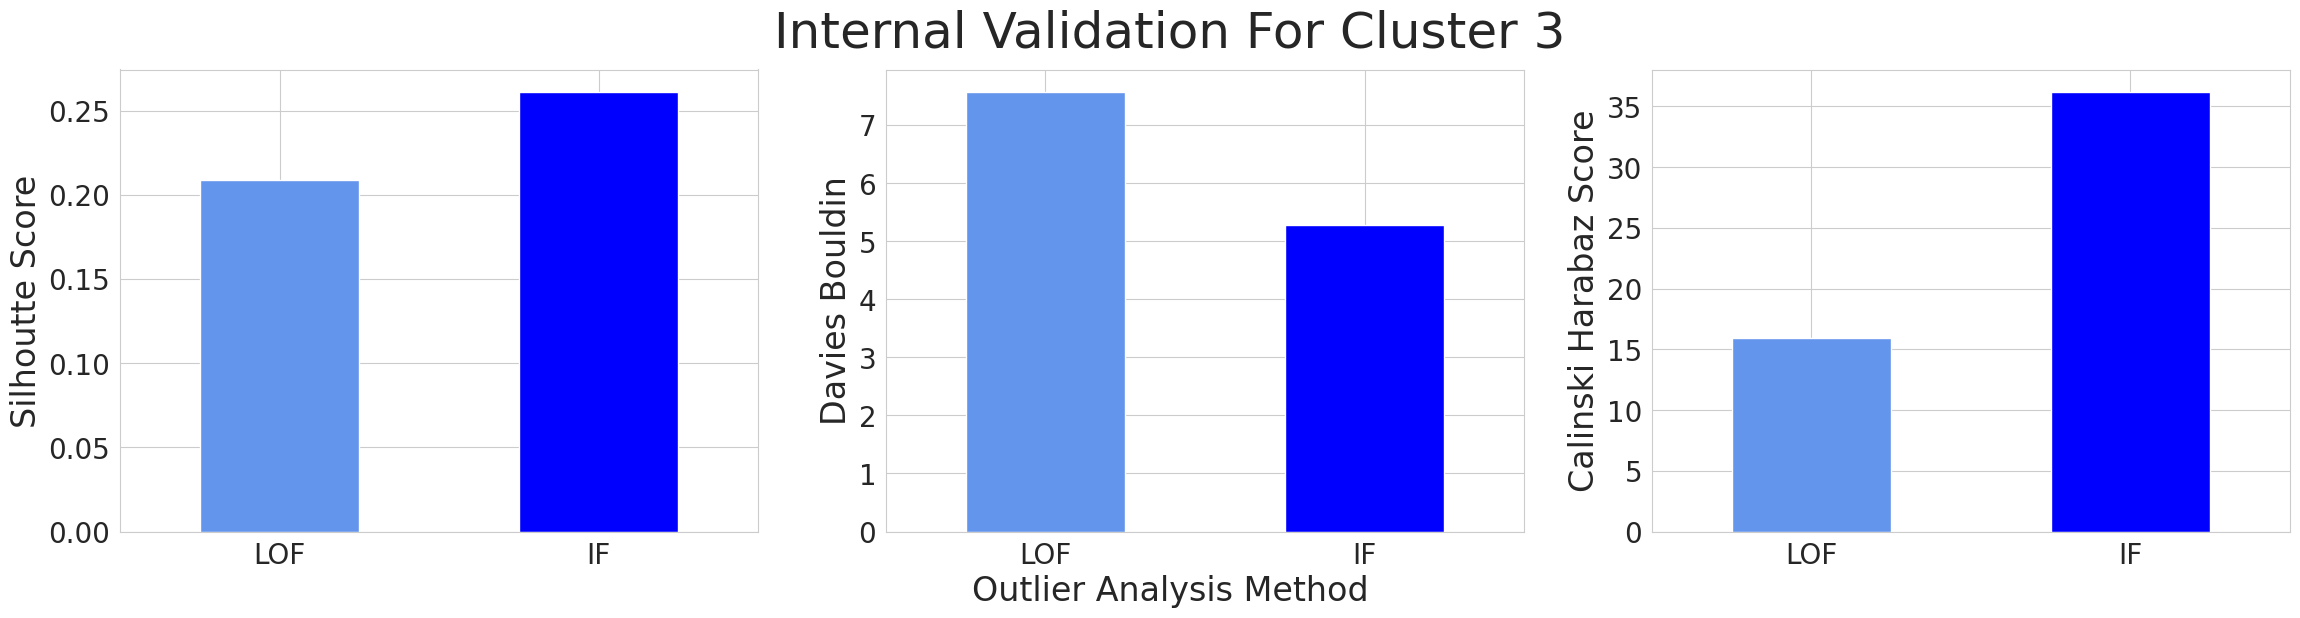

In [41]:
# Internal evaluation of the two methods
df_c3 = pd.DataFrame(index=['silhouette', 'calinski_harabaz', 
                             'davies_bouldin'])
df_c3['lof'] = internalValidation(x3, y_pred_lof3) 
df_c3['if'] = internalValidation(x3, y_pred_if3) 

# Plotting the internal evaluation for comparison
fig, ax = plt.subplots(1, 3, dpi=100, sharex=True, figsize=(28, 6))
outlier_col = ['LOF', 'IF']
fig.suptitle("Internal Validation For Cluster 3", fontsize=36)

df_c3.iloc[0].plot(kind='bar', ax=ax[0], color=['cornflowerblue', 'blue'])
ax[0].set_ylabel('Silhoutte Score', fontsize = 24)
ax[0].set_xticklabels(labels=outlier_col, rotation=0)
ax[0].tick_params(axis='both', which='major', labelsize=20)

df_c3.iloc[2].plot(kind='bar', ax=ax[1], color=['cornflowerblue', 'blue'])
ax[1].set_ylabel('Davies Bouldin', fontsize = 24)
ax[1].set_xticklabels(labels=outlier_col, rotation=0)
ax[1].tick_params(axis='both', which='major', labelsize=20)

df_c3.iloc[1].plot(kind='bar', ax=ax[2], color=['cornflowerblue', 'blue'])
ax[2].set_ylabel('Calinski Harabaz Score', fontsize = 24)
ax[2].set_xticklabels(labels=outlier_col, rotation=0)
ax[2].tick_params(axis='both', which='major', labelsize=20)

fig.text(0.5, 0.01, 'Outlier Analysis Method', ha='center', 
         va='center', fontsize=24)
plt.show()

<span style="font-size: 12px">
    <center><b>Figure 27. Internal Validation Evaluation of the Outlier Analysis for Cluster 3</b></center>
</span><br>

Cluster 3 is also the same with the previous clusters which results to Isolation Forest being the better model. All internal metrics are inclined to the IF with the difference not being close. However, the scatter plot is not as intuitive as the internal metrics since the data points of Cluster 3 is way lower in number compared to the other clusters. This is why internal validation should always be paired with the visual representation of the results. 

<a id='Results'></a>
<h1 style="color:#ffffff; background-color: #324268; border: 1px solid #324268; padding: 10px 0;">Results and Discussion</h1>

<a id='R&DC'></a>
<h2 style="color:#324268; background-color: #ffffff; border: 1px solid #ffffff; padding: 10px 0;">Clustering</h2>

The results of the clustering is summarized in the radar plot of the major categories of the attributes. This helps in identifying the characteristics of each cluster and labelling each cluster. The tabular values are also presented so exact values are also available.

- Cluster 0 includes `Midfielders` given the all-around expertise in every category except goal keeping. Midfielders are players that should be positioned in the middle of the field as they excel in offense and defense. This is so they can adapt properly in the situation of the game, whether to focus on offense or defense (or a balance of the two). Another attribute is their high physical attribute since they will be tasked to do both offensive and defensive plays.

- Cluster 1 belongs to `Defenders` since they have high defense rating, low shooting and average ball control plus passing. Defenders mostly reside at their side of the field, offering resistance to the opposing team when the opponent go on the offensive. This cluster still have decent ball control and passing skills since football is an eleven person game and controlling the ball, whether passing or dribbling is important across all players. Shooting skills are more likely an emergency skill needed at specific situations of the game. They also have a less than ideal physical attribute since most teams crowd their side of the field to make it difficult for the opponents to score.

- Cluster 2 will be the `Forwards` given the excellent shooting and ball control skills with average passing and low defense attribute. This cluster is mostly focused on the opponent's side of the field to create a lot of opportunities to score goals. They also have the highest ball control skills since they have to evade and get past the Defenders in order to score. They only have average passing since Forwards mostly rely on their individual skills rather than their teammates to score. The reason for this is the usual composition of teams having more Defenders so passing is usually riskier given the tighter space. Lastly, their physical rating is on par with the Midfielders since they have to be creative on how they score as well as be quick to get past Defenders or jump high to do headers.

- Cluster 3 is still the `Goalkeepers` given the high goalkeeping skills, average physical and the other attributes being low. Goalkeeping is a specialized skill since they have to use their hands majority of the time compared to the other players who are prohibited in using their hands during the game. This is why the other clusters have very low goalkeeping skills. This cluster is focused on only defending the goal area so they have small area to work on which results to their physical rating being low compared to the others. Other than goalkeeping, Goalkeepers should still have good passing skills so that when they stop the opponent from scoring, they will be effective in giving the ball to their teammates to counter. This cluster is the smallest with respect to the data point per cluster since teams only use one goalkeepers at a time unlike other positions who have multiple players in the same position.

As mentioned above, the clustering done is not the ideal cluster based on the internal validation metrics since it is intuitive to cluster the goalkeepers to the non-goalkeepers. This will create clusters that have minimal value to the sport since the function and role of the two is distinct to begin with. The number of cluster is a trade-off of balance and overlapping clusters but is acceptable since there are players who can do multiple roles given their attributes. Using four cluster also provides a lot of value since it narrows down the positions from fifteen to four so teams can employ different strategies and formation with limiting the position labels.

In [42]:
df_stats

Shooting  Ball_control    Passing    Defense   Physical  Goalkeeping
cluster                                                                       
0        55.945146     64.100049  66.658357  64.463474  67.765606    10.618074
1        38.348293     45.067774  52.306596  61.984032  58.492189    10.345152
2        57.134290     65.026342  56.927029  34.005563  65.273184    10.426342
3        17.652860     14.722986  26.446955  16.991945  44.568418    64.033301

<span style="font-size: 12px">
    <center><b>Table 7. Mean Player Skill Ratings of Each Cluster</b></center>
</span><br>

In [43]:
## Radar Plots are converted to image for simplicity
# radarplot([df_stats], ["All Players' Ratings"], 500, 1100, [0, 80])

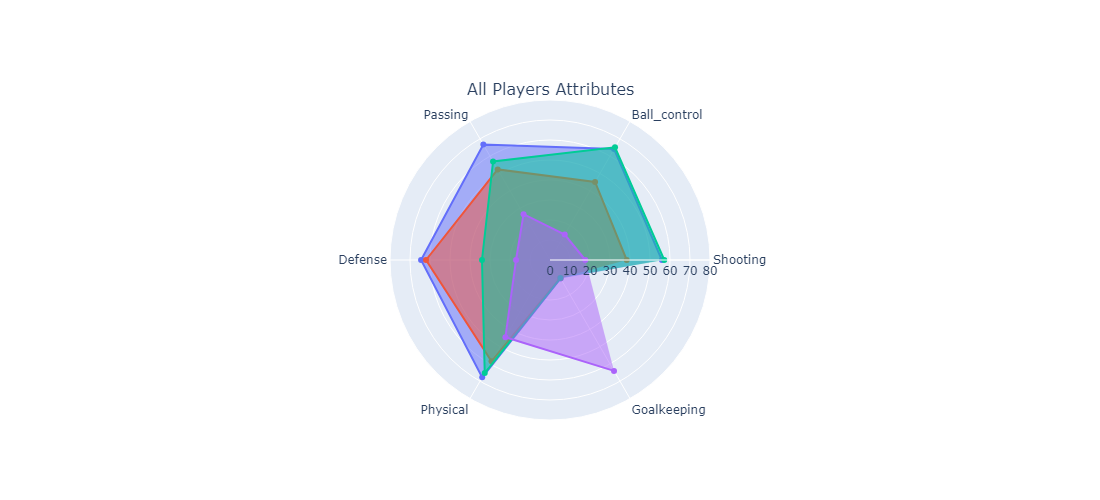

<span style="font-size: 12px">
    <center><b>Figure 28. Radar Plot of the Skill Rating of Each Cluster</b></center>
</span><br>

<a id='R&DO'></a>
<h2 style="color:#324268; background-color: #ffffff; border: 1px solid #ffffff; padding: 10px 0;">Outlier Analysis</h2>

In [44]:
# Cluster 0 Ratings
y_pred_0 = np.where(y_pred_if0 == True, 1, 0)
cluster0_f = df_cluster0.assign(outlier=y_pred_0)
cluster0_f = (cluster0_f.loc[cluster0_f.outlier == 0]
                                                  [cluster0_f.columns[:-1]])

stats_0 = pd.DataFrame()
stats_0['Shooting'] = (cluster0_f.groupby('cluster')
                                         .mean()[offense].mean(axis=1))
stats_0['Ball_control'] = (cluster0_f.groupby('cluster')
                                        .mean()[ball_control].mean(axis=1))
stats_0['Passing'] = (cluster0_f.groupby('cluster')
                                        .mean()[passing].mean(axis=1))
stats_0['Defense'] = (cluster0_f.groupby('cluster')
                                        .mean()[defense].mean(axis=1))
stats_0['Physical'] = (cluster0_f.groupby('cluster')
                                         .mean()[physical].mean(axis=1))
stats_0['Goalkeeping'] = (cluster0_f.groupby('cluster')
                                            .mean()[goalkeeping].mean(axis=1))
attrib0 = cluster0_f.groupby('cluster')[['age', 'height_cm', 
                                                     'weight_kg', 
                                                     'preferred_foot']].mean()
statsall0 = attrib0.join(stats_0)

# Cluster 1 Ratings
y_pred_1 = np.where(y_pred_if1 == True, 1, 0)
cluster1_f = df_cluster1.assign(outlier=y_pred_1)
cluster1_f = (cluster1_f.loc[cluster1_f.outlier == 0]
                                                  [cluster1_f.columns[:-1]])

stats_1 = pd.DataFrame()
stats_1['Shooting'] = (cluster1_f.groupby('cluster')
                                         .mean()[offense].mean(axis=1))
stats_1['Ball_control'] = (cluster1_f.groupby('cluster')
                                        .mean()[ball_control].mean(axis=1))
stats_1['Passing'] = (cluster1_f.groupby('cluster')
                                        .mean()[passing].mean(axis=1))
stats_1['Defense'] = (cluster1_f.groupby('cluster')
                                        .mean()[defense].mean(axis=1))
stats_1['Physical'] = (cluster1_f.groupby('cluster')
                                         .mean()[physical].mean(axis=1))
stats_1['Goalkeeping'] = (cluster1_f.groupby('cluster')
                                            .mean()[goalkeeping].mean(axis=1))
attrib1 = cluster1_f.groupby('cluster')[['age', 'height_cm', 
                                                     'weight_kg', 
                                                     'preferred_foot']].mean()
statsall1 = attrib1.join(stats_1)

# Cluster 2 Ratings
y_pred_2 = np.where(y_pred_if2 == True, 1, 0)
cluster2_f = df_cluster2.assign(outlier=y_pred_2)
cluster2_f = (cluster2_f.loc[cluster2_f.outlier == 0]
                                                  [cluster2_f.columns[:-1]])

stats_2 = pd.DataFrame()
stats_2['Shooting'] = (cluster2_f.groupby('cluster')
                                         .mean()[offense].mean(axis=1))
stats_2['Ball_control'] = (cluster2_f.groupby('cluster')
                                        .mean()[ball_control].mean(axis=1))
stats_2['Passing'] = (cluster2_f.groupby('cluster')
                                        .mean()[passing].mean(axis=1))
stats_2['Defense'] = (cluster2_f.groupby('cluster')
                                        .mean()[defense].mean(axis=1))
stats_2['Physical'] = (cluster2_f.groupby('cluster')
                                         .mean()[physical].mean(axis=1))
stats_2['Goalkeeping'] = (cluster2_f.groupby('cluster')
                                            .mean()[goalkeeping].mean(axis=1))
attrib2 = cluster2_f.groupby('cluster')[['age', 'height_cm', 
                                                     'weight_kg', 
                                                     'preferred_foot']].mean()
statsall2 = attrib2.join(stats_2)

# Cluster 3 Ratings
y_pred_3 = np.where(y_pred_if3 == True, 1, 0)
cluster3_f = df_cluster3.assign(outlier=y_pred_3)
cluster3_f = (cluster3_f.loc[cluster3_f.outlier == 0]
                                                  [cluster3_f.columns[:-1]])

stats_3 = pd.DataFrame()
stats_3['Shooting'] = (cluster3_f.groupby('cluster')
                                         .mean()[offense].mean(axis=1))
stats_3['Ball_control'] = (cluster3_f.groupby('cluster')
                                        .mean()[ball_control].mean(axis=1))
stats_3['Passing'] = (cluster3_f.groupby('cluster')
                                        .mean()[passing].mean(axis=1))
stats_3['Defense'] = (cluster3_f.groupby('cluster')
                                        .mean()[defense].mean(axis=1))
stats_3['Physical'] = (cluster3_f.groupby('cluster')
                                         .mean()[physical].mean(axis=1))
stats_3['Goalkeeping'] = (cluster3_f.groupby('cluster')
                                            .mean()[goalkeeping].mean(axis=1))
attrib3 = cluster3_f.groupby('cluster')[['age', 'height_cm', 
                                                     'weight_kg', 
                                                     'preferred_foot']].mean()
statsall3 = attrib3.join(stats_3)

# Normalized Position Ratings
inlier_stats = pd.concat([stats_0, stats_1, stats_2, stats_3])
inlier_statsall = pd.concat([statsall0, statsall1, statsall2, statsall3])

In [45]:
# Cluster 0 Ratings
y_pred_0 = np.where(y_pred_if0 == True, 1, 0)
cluster0_f = df_cluster0.assign(outlier=y_pred_0)
cluster0_f = (cluster0_f.loc[cluster0_f.outlier == 1]
                                                  [cluster0_f.columns[:-1]])

stats_0 = pd.DataFrame()
stats_0['Shooting'] = (cluster0_f.groupby('cluster')
                                         .mean()[offense].mean(axis=1))
stats_0['Ball_control'] = (cluster0_f.groupby('cluster')
                                        .mean()[ball_control].mean(axis=1))
stats_0['Passing'] = (cluster0_f.groupby('cluster')
                                        .mean()[passing].mean(axis=1))
stats_0['Defense'] = (cluster0_f.groupby('cluster')
                                        .mean()[defense].mean(axis=1))
stats_0['Physical'] = (cluster0_f.groupby('cluster')
                                         .mean()[physical].mean(axis=1))
stats_0['Goalkeeping'] = (cluster0_f.groupby('cluster')
                                            .mean()[goalkeeping].mean(axis=1))
attrib0 = cluster0_f.groupby('cluster')[['age', 'height_cm', 
                                                     'weight_kg', 
                                                     'preferred_foot']].mean()
statsall0 = attrib0.join(stats_0)

# Cluster 1 Ratings
y_pred_1 = np.where(y_pred_if1 == True, 1, 0)
cluster1_f = df_cluster1.assign(outlier=y_pred_1)
cluster1_f = (cluster1_f.loc[cluster1_f.outlier == 1]
                                                  [cluster1_f.columns[:-1]])

stats_1 = pd.DataFrame()
stats_1['Shooting'] = (cluster1_f.groupby('cluster')
                                         .mean()[offense].mean(axis=1))
stats_1['Ball_control'] = (cluster1_f.groupby('cluster')
                                        .mean()[ball_control].mean(axis=1))
stats_1['Passing'] = (cluster1_f.groupby('cluster')
                                        .mean()[passing].mean(axis=1))
stats_1['Defense'] = (cluster1_f.groupby('cluster')
                                        .mean()[defense].mean(axis=1))
stats_1['Physical'] = (cluster1_f.groupby('cluster')
                                         .mean()[physical].mean(axis=1))
stats_1['Goalkeeping'] = (cluster1_f.groupby('cluster')
                                            .mean()[goalkeeping].mean(axis=1))
attrib1 = cluster1_f.groupby('cluster')[['age', 'height_cm', 
                                                     'weight_kg', 
                                                     'preferred_foot']].mean()
statsall1 = attrib1.join(stats_1)

# Cluster 2 Ratings
y_pred_2 = np.where(y_pred_if2 == True, 1, 0)
cluster2_f = df_cluster2.assign(outlier=y_pred_2)
cluster2_f = (cluster2_f.loc[cluster2_f.outlier == 1]
                                                  [cluster2_f.columns[:-1]])

stats_2 = pd.DataFrame()
stats_2['Shooting'] = (cluster2_f.groupby('cluster')
                                         .mean()[offense].mean(axis=1))
stats_2['Ball_control'] = (cluster2_f.groupby('cluster')
                                        .mean()[ball_control].mean(axis=1))
stats_2['Passing'] = (cluster2_f.groupby('cluster')
                                        .mean()[passing].mean(axis=1))
stats_2['Defense'] = (cluster2_f.groupby('cluster')
                                        .mean()[defense].mean(axis=1))
stats_2['Physical'] = (cluster2_f.groupby('cluster')
                                         .mean()[physical].mean(axis=1))
stats_2['Goalkeeping'] = (cluster2_f.groupby('cluster')
                                            .mean()[goalkeeping].mean(axis=1))
attrib2 = cluster2_f.groupby('cluster')[['age', 'height_cm', 
                                                     'weight_kg', 
                                                     'preferred_foot']].mean()
statsall2 = attrib2.join(stats_2)

# Cluster 3 Ratings
y_pred_3 = np.where(y_pred_if3 == True, 1, 0)
cluster3_f = df_cluster3.assign(outlier=y_pred_3)
cluster3_f = (cluster3_f.loc[cluster3_f.outlier == 1]
                                                  [cluster3_f.columns[:-1]])

stats_3 = pd.DataFrame()
stats_3['Shooting'] = (cluster3_f.groupby('cluster')
                                         .mean()[offense].mean(axis=1))
stats_3['Ball_control'] = (cluster3_f.groupby('cluster')
                                        .mean()[ball_control].mean(axis=1))
stats_3['Passing'] = (cluster3_f.groupby('cluster')
                                        .mean()[passing].mean(axis=1))
stats_3['Defense'] = (cluster3_f.groupby('cluster')
                                        .mean()[defense].mean(axis=1))
stats_3['Physical'] = (cluster3_f.groupby('cluster')
                                         .mean()[physical].mean(axis=1))
stats_3['Goalkeeping'] = (cluster3_f.groupby('cluster')
                                            .mean()[goalkeeping].mean(axis=1))
attrib3 = cluster3_f.groupby('cluster')[['age', 'height_cm', 
                                                     'weight_kg', 
                                                     'preferred_foot']].mean()
statsall3 = attrib3.join(stats_3)

# Ratings of Outlier Players per Cluster
outlier_stats = pd.concat([stats_0, stats_1, stats_2, stats_3])
outlier_statsall = pd.concat([statsall0, statsall1, statsall2, statsall3])

The outlier analysis is aimed toward normalizing the ratings of each cluster so teams can clearly separate to positions and removed the overlaps between the clusters. Filtering the clusters by outlier detection goes both ways, it identifies both highly rated players in the cluster as well as the low rated players. So before looking at the what should be the normalized ratings for every position, the outliers should be analyzed first to check which dominates the outliers. For this, the values of the outliers will be projected as radar plot as well as check the difference between outlier and inlier ratings.

- The outliers of Midfielders (Cluster 0) are players will higher ratings in every aspect, most notable on the shooting, ball control and passing skills. The physical and defending skills of the outliers are also better with the goalkeeping being almost the same. This means that the outliers are highly exceptional players or superstars which are inclined to having more offensive roles than defensive roles.
- For Defenders (Cluster 1), the outliers are players that are more specialized to the defensive ratings but also have increased shooting attributes which is unusual since Defenders have limited offensive roles. The increase in that two areas result to trading off attributes in ball control, passing and physical since they have to focus on defense alone.
- The outliers of Forwards (Cluster 2) have their shooting skills being way better, which is the same trend for the ball control and passing ratings. For the defense, outliers also has highers ratings which makes sense since getting back the ball at the opponent's side of the court is a huge advantage to the team. However, the physical ratings have a small increase which may be due to the Forwards having good physical ratings in general. This also means that highly exceptional players does not need to have physical advantage over the rest to become the best Forwards.
- For Goalkeepers (Cluster 3), the better ratings in goalkeeping, passing and physical for outliers are expected since as mentioned, it is the core skill of the position. The better shooting is also unusual since they should be the last player to be scoring for the team. The increase in ball control is for Goalkeepers may be due to situation where the Goalkeeper must handle the ball when passed by a teammate to set up a play or formation.

Looking at the behavior of the outliers, it can be observed that the outliers are general an improved version of the players in each position. The Defenders are only the one trading off an attribute to be better at a specific category but the others have every category increased.

In [46]:
outlier_stats - df_stats

Shooting  Ball_control   Passing   Defense  Physical  Goalkeeping
cluster                                                                   
0        5.686184      5.566617  5.905578  3.285051  2.268492     0.076024
1        0.692136     -0.561174 -0.093724  1.656562 -1.284269     0.076630
2        4.157105      3.107101  3.113821  2.795744  0.296914     0.003724
3        0.509450      1.105445  3.459908  0.736486  2.760503     3.469641

<span style="font-size: 12px">
    <center><b>Table 8. Difference of the Mean Outlier Ratings to All Player Ratings</b></center>
</span><br>

In [47]:
# radarplot([outlier_stats], ["Ideal Ratings per Position"], 500, 1100, [0, 80])

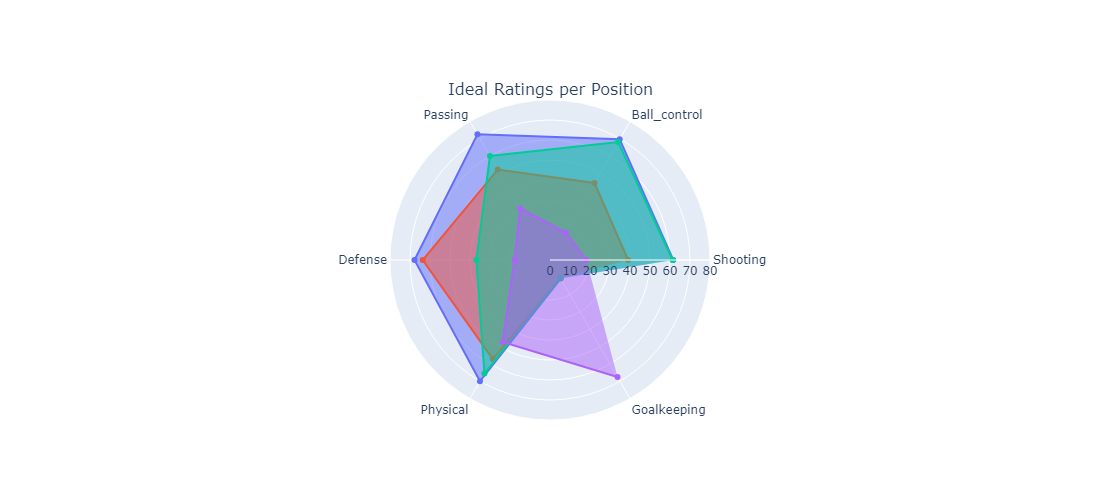

In [48]:
# Cluster 0 ratings of All, Outlier and Inlier
rplot0 = pd.concat([df_stats.iloc[[0]], outlier_stats.iloc[[0]], 
                    inlier_stats.iloc[[0]]])
rplot0.index = ['All', 'Outlier', 'Inlier']

# Cluster 1 ratings of All, Outlier and Inlier
rplot1 = pd.concat([df_stats.iloc[[1]], outlier_stats.iloc[[1]], 
                    inlier_stats.iloc[[1]]])
rplot1.index = ['All', 'Outlier', 'Inlier']

rplot2 = pd.concat([df_stats.iloc[[2]], outlier_stats.iloc[[2]], 
                    inlier_stats.iloc[[2]]])
rplot2.index = ['All', 'Outlier', 'Inlier']

rplot3 = pd.concat([df_stats.iloc[[3]], outlier_stats.iloc[[3]], 
                    inlier_stats.iloc[[3]]])
rplot3.index = ['All', 'Outlier', 'Inlier']

# radarplot([rplot0, rplot1], 
#           ['Midfielders', 'Defenders'],
#          400, 1100, [0, 90])

In [49]:
# radarplot([rplot2, rplot3], 
#           ['Forwards', 'Goalkeepers'],
#          400, 1100, [0, 90])

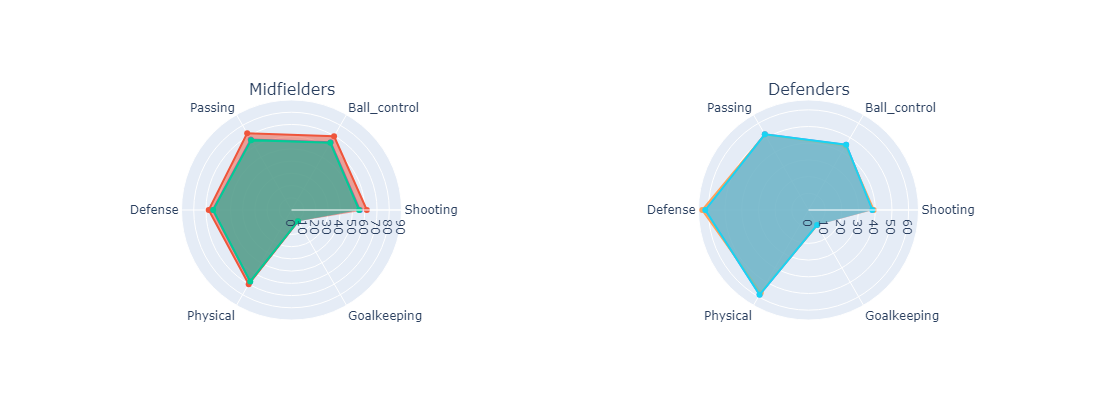

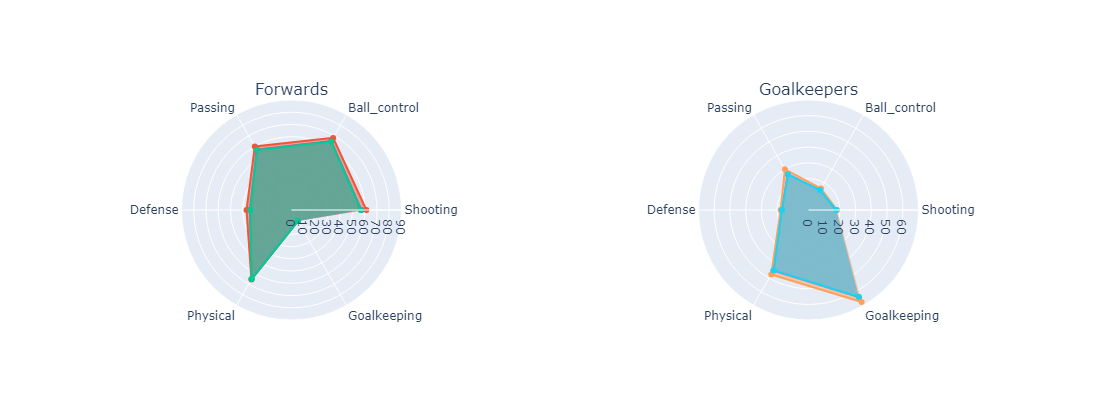

<span style="font-size: 12px">
    <center><b>Figure 29. Radar Plot of the Skill Rating of the Outlier and Inlier Player Ratings per Position</b></center>
</span><br>

Normalizing the ratings of every position, the outliers (which are identified as the star players at their position) are filtered. This resulted to the following observations:

- Improving physical attributes has minimal factor in being an outlier. This means that outlier players have the same physical characteristics as the average player so focusing on improving one's physique will not guarantee being a highly rated football player.
- Ratings of Defenders and Goalkeepers are already normalized. The change from the unnormalized value to the normalized values for these clusters are small which suggests either one of the following: the outliers are a mix of high rated and low rated players, and it takes only a small increase in attributes of Defenders and Goalkeepers to be an outlier.
- Offensive ratings are what separated star Midfielders and Forwards. Normalizing the ratings of both clusters resulted to the shooting and ball control skills being lowered greatly compared to the other attributes. This may follow the trend of offense being the defining factor for these two positions which suggest individualistic plays are the star players. 

In [50]:
inlier_stats

Shooting  Ball_control    Passing    Defense   Physical  Goalkeeping
cluster                                                                       
0        55.313002     63.481198  66.001822  64.098269  67.513414    10.609623
1        38.271241     45.130247  52.317029  61.799614  58.635161    10.336622
2        56.671717     64.680606  56.580545  33.694473  65.240145    10.425927
3        17.596131     14.599891  26.061681  16.909934  44.261026    63.646943

<span style="font-size: 12px">
    <center><b>Table 9. Normalized Player Ratings per Position</b></center>
</span><br>

In [51]:
# radarplot([inlier_stats], ["Normalized per Position"], 500, 1100, [0, 80])

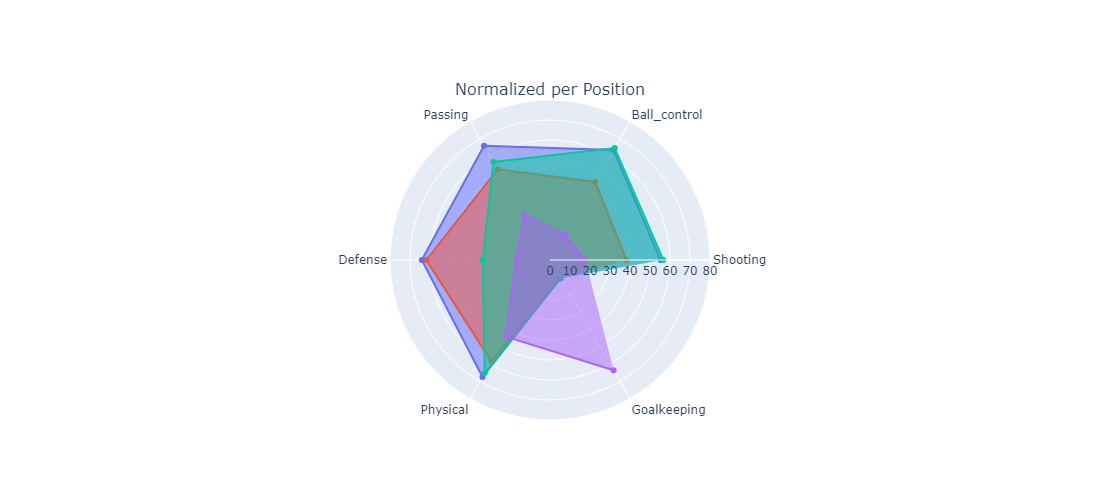

<span style="font-size: 12px">
    <center><b>Figure 30. Radar Plot of the Normalized Skill Rating per Position</b></center>
</span><br>

<a id='Conclusion'></a>
<h1 style="color:#ffffff; background-color: #324268; border: 1px solid #324268; padding: 10px 0;">Conclusion</h1>

In this project, we were able to identify possible directions for improvement for each position and other general insights using clustering techniques and outlier analysis. By applying soft clustering to the players, we were able to successfully separate them by their positions. We found that the optimal number of cluster based on the dataset is four and defined the labels of the members are:
* Cluster 0 are the midfielders, 
* Cluster 1 are the defenders, 
* Cluster 2 are the forwards, and 
* Cluster 3 are the goalkeepers. 

By performing outlier analysis, we were able to identify outliers in each position. When we compared the stats of outliers with inliers, we found that generally, outlier players are improved versions of their inlier counterparts. Lastly, by normalizing the player ratings for every position through filtering the outliers, we were able to extract a few insights like:
* Improving physical attributes does not guarantee that one will be a highly rated player
* Defender and goalkeeper ratings are already normalized, which means that either the outliers are a mix of high rated and low rated players, or that it takes only a small increase in attributes of defenders and goalkeepers to be an outlier
* Offensive ratings are the defining factors of midfielders and forwards which suggests that star players go for more individualistic plays.

<a id='Recommendation1'></a>
<h1 style="color:#ffffff; background-color: #324268; border: 1px solid #324268; padding: 10px 0;">Recommendations</h1>

<a id='Limitations'></a>
<h2 style="color:#324268; background-color: #ffffff; border: 1px solid #ffffff; padding: 10px 0;">Limitations of the Study</h2>

There are some assumptions and limitations that we made in doing this project. We have identified some limitations as the following:
* Attributes are estimates based on the FIFA video game which may not reflect real skill ratings of players
* Assumed parsimonious clusters even when we dont know the actual position distribution of players
* Mislabelled player positions imply that there might be cluster outliers that are just mislabelled players from a different cluster 
* Our dataset only reflects data up to the 2020 roster which implies that our findings are a few years behind
* For looking at the ratings, the categories are just the average value of the ratings which can be easily affected by extreme values

<a id='Recommendation2'></a>
<h2 style="color:#324268; background-color: #ffffff; border: 1px solid #ffffff; padding: 10px 0;">Recommendations and Future Work</h2>

To improve our work further, we suggest the following recommendations:
* Identify other attributes that can be critical in defining the positions or better aggregation of the ratings.
* Look at the different timelines in order to visualize the trend and evolution of the game
* It would be interesting to see if these outlier players perform well in games as the dataset suggests
* Explore different contamination levels for outlier analysis
* The same analysis in this study may also be applied to other professional football leagues outside of the FIFA World cup

<a id='References'></a>
<h1 style="color:#ffffff; background-color: #324268; border: 1px solid #324268; padding: 10px 0;">References</h1>

[1] FIFPlay. (n.d.) FIFA 22 Attributes Explained. Retrieved from https://www.fifplay.com/fifa-22-player-attributes/

[2] Sean Wright. (2022, Oct 08) Soccer positions and numbers: A complete guide. Retrieved from https://www.redbull.com/us-en/soccer-numbers-positions-guide

[3] Rukshan Pramoditha. (2021, Dec 09) 11 Different Uses of Dimensionality Reduction. Retrieved from https://data-flair.training/blogs/dimensionality-reduction-tutorial/

[4] Sauravkaushik Kaushik. (2023, May 02) Clustering: Introduction, Different Methods, and Applications. Retrieved from https://www.analyticsvidhya.com/blog/2016/11/an-introduction-to-clustering-and-different-methods-of-clustering/

[5] Jay Singh. (2023, Apr 25) How to Evaluate the Performance of Clustering Models? Retrieved from https://www.tutorialspoint.com/how-to-evaluate-the-performance-of-clustering-models

[6]  Ajitesh Kumar. (2023, May 08) Gaussian Mixture Models: What are they & when to use? Retrieved from https://vitalflux.com/gaussian-mixture-models-what-are-they-when-to-use/

[7] Marina Chatterjee. (2022, Oct 24) Introduction to Spectral Clustering. Retrieved from https://www.mygreatlearning.com/blog/introduction-to-spectral-clustering/

[8] InterviewBit. (2023, May 06) Outlier Analysis in Data Mining. Retrieved from https://www.scaler.com/topics/data-mining-tutorial/outlier-analysis-in-data-mining/

[9] Vaibhav Jayaswal. (2020, Aug 31) Local Outlier Factor (LOF) — Algorithm for outlier identification. Retrieved from https://towardsdatascience.com/local-outlier-factor-lof-algorithm-for-outlier-identification-8efb887d9843

[10] Muhammad Khan. (2020, Jan 1) Anomaly Detection with Isolation Forest and Kernel Density Estimation. Retrieved from https://machinelearningmastery.com/anomaly-detection-with-isolation-forest-and-kernel-density-estimation/